In [299]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import PolynomialFeatures as polyfeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gspread as gs
import gspread_dataframe as gd
import copy
import itertools

%matplotlib inline
plt.style.use('fivethirtyeight')

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2,read_consesus,read_fre
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,8.0,88.77
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,6.0,89.99
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,6.0,99.77


In [300]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]

In [301]:
# Check missing data patterns
missing = tss_df[item_labels_li].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

# in this case it is straightforward - just drop the 3 rows with missing data
tss_df.dropna(subset=item_labels_li, inplace=True)

# if missing data should be more common with small amounts of missing data per case, might need different approach obv

Top 5 cols with missing data per col:
tss_pac_9     3
tss_qua_2     3
tss_rep_9     3
tss_coh_2     3
tss_cre_10    3
dtype: int64

Top 5 missing data per row:
117    72
137    65
77     35
0       0
194     0
dtype: int64


In [302]:
# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations than I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     50.273973
std      11.132111
min      26.000000
25%      42.000000
50%      50.000000
75%      60.000000
max      70.000000
dtype: float64


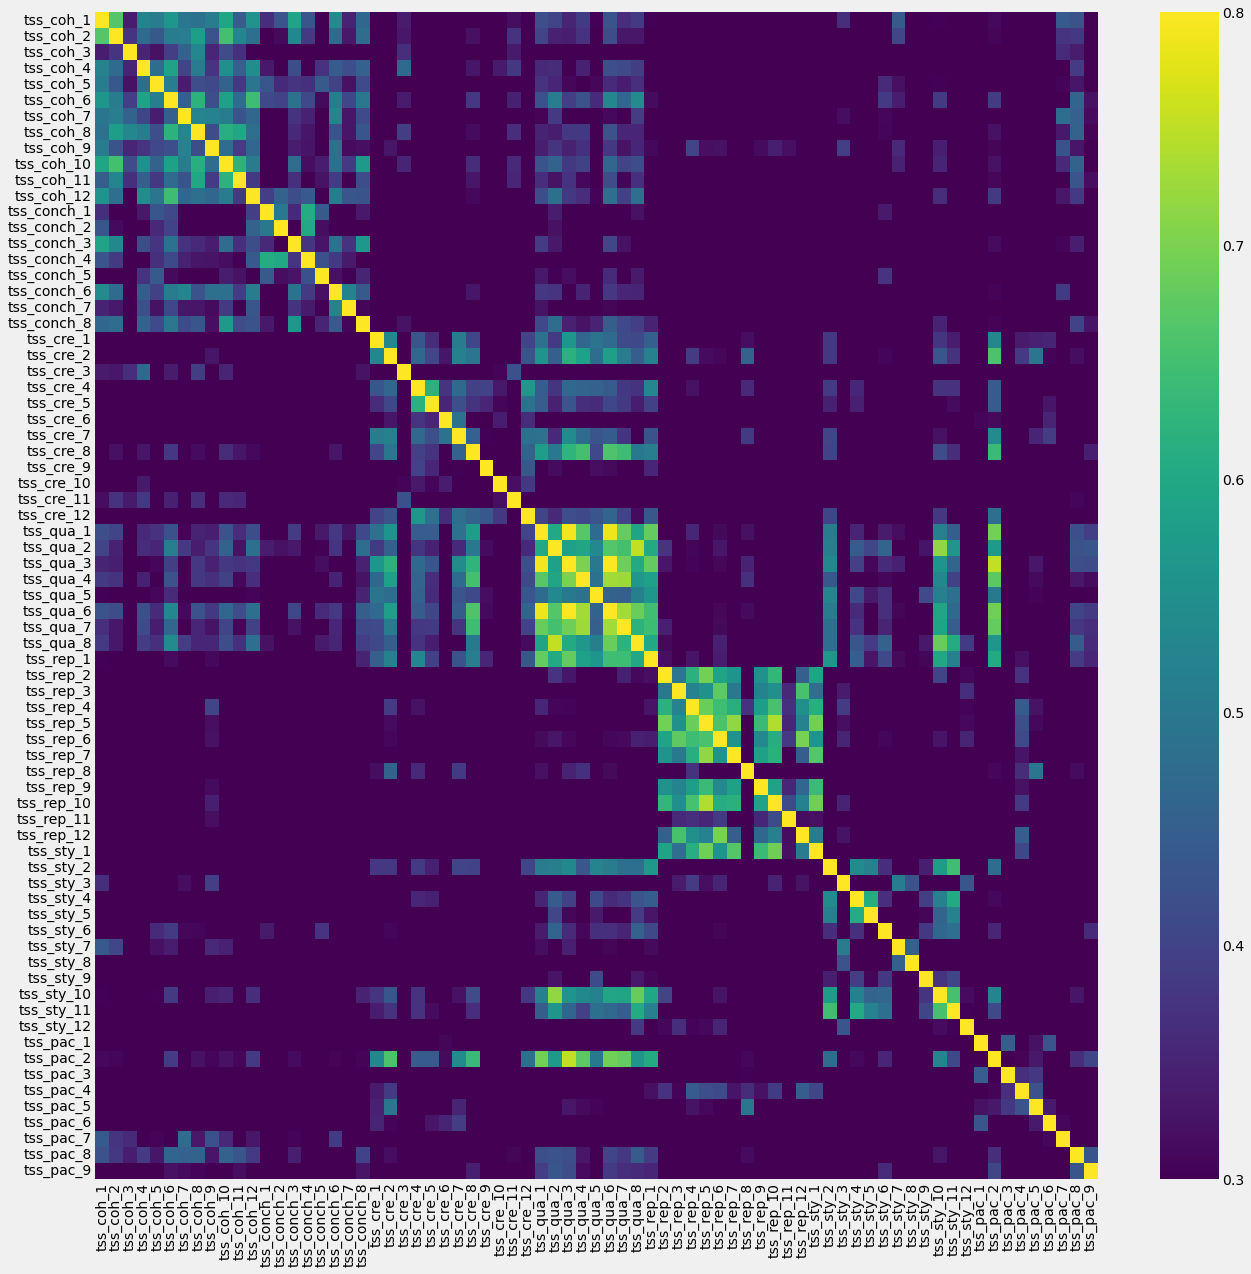

In [303]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [304]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_cre_3", "tss_cre_10", "tss_cre_11",
    "tss_rep_8", "tss_rep_10",
    "tss_sty_7", "tss_sty_8", "tss_sty_9", "tss_sty_12"
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6", "tss_pac_9"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_cre_3: The plot development in the story was predictable.
Correlations >= .3:
tss_coh_3      0.365549
tss_coh_4      0.469240
tss_coh_6      0.336569
tss_coh_8      0.388309
tss_coh_10     0.349078
tss_conch_8    0.323777
tss_cre_11     0.423666

tss_cre_10: The story was unconventional.
Correlations >= .3:
tss_cre_4     0.332808
tss_cre_5     0.307672
tss_cre_6     0.337171
tss_cre_12    0.380408

tss_cre_11: The plot was typical for this kind of story.
Correlations >= .3:
tss_coh_3     0.333483
tss_coh_4     0.380357
tss_coh_6     0.344575
tss_coh_8     0.362661
tss_coh_10    0.356355
tss_coh_11    0.350909
tss_cre_3     0.423666
tss_pac_8     0.305920

tss_rep_8: The plot had no development.
Correlations >= .3:
tss_cre_2    0.457108
tss_rep_4    0.373529
tss_pac_3    0.303847
tss_pac_4    0.361308
tss_pac_5    0.495497

tss_rep_10: Characters said or did the same thing many times over.
Correlations >= .3:
tss_coh_9     0.342085
tss_rep_3     0.549531
tss_rep_4     0.654081
tss_r

In [305]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

# excluded_items_li = [
#     "tss_sty_8"
# ]

# for item in excluded_items_li:
#     items_analysis_li.remove(item)

In [306]:
# Check for multicollinearity
def reduce_multicoll(df, vars_li, vars_descr=[], print_details=True):
    reduced_vars = copy.deepcopy(vars_li)
    print("Beginning check for multicollinearity")
    vars_corr = df[reduced_vars].corr()
    det = np.linalg.det(vars_corr)
    print("\nDeterminant of initial correlation matrix: {}\n".format(det))

    if det > .00001:
        print("Determinant is > .00001. No issues with multicollinearity detected.")
        return(reduced_vars)

    print("Starting to remove redundant variables by acessing mutlicollinearity with VIF...\n")
    count_missing = len(df) - len(df.dropna(subset=vars_li))
    if count_missing > 0:
        print("This requries dropping missing values.",
              "The following procedure will ignore {} cases with missing values".format(count_missing))
    while det <= .00001:
        # could implement pairwise dropping of missing here at some point
        # but until you have a case with lots of missing data, this will work fine
        x_df = df.dropna(subset=vars_li)[reduced_vars]
        vifs = [vif(x_df.values, i)
                for i in range(len(x_df.columns))]
        vif_data = pd.Series(vifs, index=x_df.columns)
        vif_max = (vif_data.idxmax(), vif_data.max())

        if print_details:
            print("Excluded item {}. VIF: {:.2f}".format(
                vif_max[0], vif_max[1]))

            if len(vars_descr) > 0:
                print("('{}')".format(vars_descr[vif_max[0]]))
            print("")

        reduced_vars.remove(vif_max[0])

        vars_corr = df[reduced_vars].corr()
        det = np.linalg.det(vars_corr)

    print("Done! Determinant is now: {:.6f}".format(det))
    count_removed = len(vars_li) - len(reduced_vars)
    print("I have excluded {} redunant items with {} items remaining".format(
        count_removed, len(reduced_vars)))

    return(reduced_vars)

In [307]:
items_analysis_li = reduce_multicoll(
    tss_df, items_analysis_li, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 1.3939216144846823e-23

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_qua_3. VIF: 38.35
('The story was fun to read.')

Excluded item tss_qua_6. VIF: 31.47
('I liked this story.')

Excluded item tss_coh_12. VIF: 31.07
('The story lacked logic.')

Excluded item tss_coh_1. VIF: 28.63
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_qua_1. VIF: 26.08
('This story was enjoyable.')

Excluded item tss_rep_5. VIF: 24.96
('In the story, the same things happened again and again.')

Excluded item tss_cre_4. VIF: 24.49
('The story was creative.')

Excluded item tss_cre_2. VIF: 24.14
('The story was boring.')

Excluded item tss_qua_8. VIF: 24.01
('The story was well-written.')

Excluded item tss_conch_5. VIF: 23.77
('The descriptions of characters in the story were plausible.')

Excluded item tss_rep_4. VIF: 23.48
('The stor

In [308]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=1, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.8520553208660439
All item KMOs are >.6


In [309]:
# Determine number of factors
# Use Screeplot & Parallel Analysis

# Function to output results for parallel parallel analysis
def parallel_analysis(df, vars_li, k=100, facs_to_display=15, print_graph=True, print_table=True):
    # EFA with no rotation to get EVs
    efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # EVs for actual data
    efa.fit(df[vars_li])
    ev_pca, ev_efa = efa.get_eigenvalues()

    # Prepare random data for parallel analysis
    n, m = df[vars_li].shape
    par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # Create df to store the values
    ev_par_df = pd.DataFrame(columns=range(1, m+1))

    # Run the fit 'k' times over a random matrix
    for runNum in range(0, k):
        par_efa.fit(np.random.normal(size=(n, m)))
        cur_ev_ser = pd.Series(par_efa.get_eigenvalues()[
                               1], index=ev_par_df.columns)
        ev_par_df = ev_par_df.append(cur_ev_ser, ignore_index=True)
    # get 95th percentile for the evs
    par_95per = ev_par_df.quantile(0.95)

    if print_graph:
        # Draw graph
        plt.figure(figsize=(10, 6))

        # Line for eigenvalue 1
        plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
        # For the random data (parallel analysis)
        plt.plot(range(1, len(par_95per[:facs_to_display])+1),
                 par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
        # Markers and line for actual EFA eigenvalues
        plt.scatter(
            range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
        plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
                 ev_efa[:facs_to_display], label='EVs - survey data')

        plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
        plt.xlabel('Components', {'fontsize': 15})
        plt.xticks(ticks=range(1, facs_to_display+1),
                   labels=range(1, facs_to_display+1))
        plt.ylabel('Eigenvalue', {'fontsize': 15})
        plt.legend()
        plt.show()

    if print_table:
        # Create simple table with values for 95th percentile for random data and EVs for actual data
        print("Factor eigenvalues for the 95th percentile of {} random matricesand for survey data for first {} factors:\n".
              format(k, facs_to_display))
        print("\033[1mFactor\tEV - random data 95h perc.\tEV survey data\033[0m")

        last_index = 0
        last_95per_par = 0
        last_ev_efa = 0
        found_threshold = False

        # Loop that prints previous (!) values
        # if current EV from survey data is smaller than 95th percentile from random data, we reached the threshold
        # in that case print the previous values in bold as it marks the number of factors determined by parallel analysis
        for index, cur_ev_par in par_95per[:facs_to_display].iteritems():
            cur_ev_efa = ev_efa[index-1]
            if (index > 1) & (cur_ev_par >= cur_ev_efa) & (found_threshold == False):
                found_threshold = True
                print("\033[1m{}\t{:.2f}\t\t\t\t{:.2f}\033[0m".format(
                    last_index, last_95per_par, last_ev_efa))
            elif (index > 1):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    last_index, last_95per_par, last_ev_efa))

            if index == len(par_95per[:facs_to_display]):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    index, cur_ev_par, cur_ev_efa))

            last_index = index
            last_95per_par = cur_ev_par
            last_ev_efa = cur_ev_efa

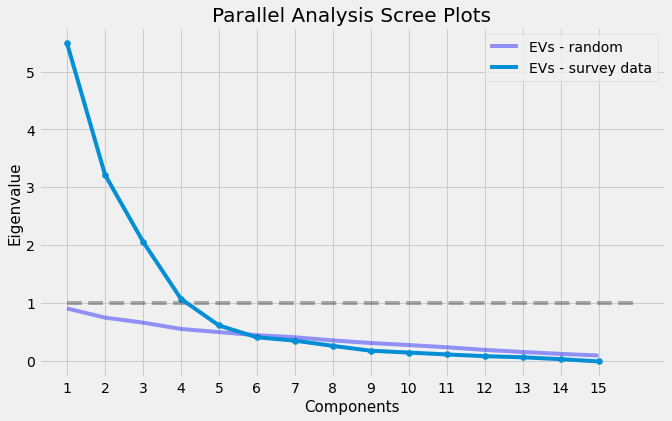

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.90				5.49
2	0.74				3.21
3	0.66				2.06
4	0.55				1.07
5	0.49				0.61
6	0.44				0.40
7	0.40				0.35
8	0.35				0.25
9	0.30				0.17
10	0.27				0.14
11	0.23				0.11
12	0.19				0.08
13	0.15				0.06
14	0.12				0.02
15	0.09				-0.01


In [310]:
parallel_analysis(tss_df, items_analysis_li)

# determine factors to investigate based on screeplot and parallel analysis
# if both methods yield different results, examine both number of factors
# (decide for one based on whether you get a clean solution and on how interpretable the solution is)

## 5 factor solution

In [311]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=5, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique


Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.0389745  -0.24184858  0.11166122 -0.43904274]
 [ 0.0389745   1.          0.15950781 -0.25621915  0.01040872]
 [-0.24184858  0.15950781  1.         -0.01371861  0.2894801 ]
 [ 0.11166122 -0.25621915 -0.01371861  1.         -0.13590139]
 [-0.43904274  0.01040872  0.2894801  -0.13590139  1.        ]]


In [312]:
def stepwise_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                 comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                 print_details=False, print_par_plot=False, print_par_table=False,
                 par_k=100, par_n_facs=15, iterative=True):

    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    curr_vars = copy.deepcopy(vars_analsis)

    efa.fit(data[curr_vars])

    if print_par_plot or print_par_table:
        parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                          print_graph=print_par_plot, print_table=print_par_table)

    # Check 1: Check communcalities
    print("Checking for low communalities")
    comms = pd.DataFrame(efa.get_communalities(),
                         index=tss_df[curr_vars].columns, columns=['Communality'])
    mask_low_comms = comms["Communality"] < comm_thresh

    if comms[mask_low_comms].empty:
        print("All communalities above {}\n".format(comm_thresh))
    else:
        # save bad items and remove them
        bad_items = comms[mask_low_comms].index
        print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
            len(bad_items)))
        for item in bad_items:
            if print_details:
                print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                    item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)

    # Check 2: Check for low main loading
    print("Checking for low main loading")
    loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
    max_loadings = abs(loadings).max(axis=1)
    mask_low_main = max_loadings < main_thresh
    if max_loadings[mask_low_main].empty:
        print("All main loadings above {}\n".format(main_thresh))
    else:
        # save bad items and remove them
        bad_items = max_loadings[mask_low_main].index
        print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
            len(bad_items)))
        for item in bad_items:
            if print_details:
                print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                    item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)

    # check 3: Check for high cross loadings
    print("Checking high cross loadings")

    # create df that stores main_load, largest crossload and difference between the two
    crossloads_df = pd.DataFrame(index=curr_vars)

    crossloads_df["main_load"] = abs(loadings).max(axis=1)
    crossloads_df["cross_load"] = abs(loadings).apply(
        lambda row: row.nlargest(2).values[-1], axis=1)
    crossloads_df["diff"] = crossloads_df["main_load"] - \
        crossloads_df["cross_load"]

    mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
        crossloads_df["diff"] < load_diff_thresh)

    if crossloads_df[mask_high_cross].empty:
        print("All cross_loadins loadings below {}".format(cross_thres),
              "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
    else:
        # save bad items and remove them
        bad_items = crossloads_df[mask_high_cross].index
        print("Detected {} items with high cross loading. Excluding them for next analysis.\n"
              .format(len(bad_items)))
        for item in bad_items:
            if print_details:
                print("Removed item {}: {}\nLoadings: \n{}\n".format(
                    item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)

    corrs = data[curr_vars].corr()
    det = np.linalg.det(corrs)
    print("\nDeterminant of correlation matrix: {}".format(det))
    if det > 0.00001:
        print("Determinant looks good!")
    else:
        print("Determinant is smaller than 0.00001!")
        print("Consider using stricer criteria and/or removing highly correlated vars")

    kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
    print("Overall KMO: {}".format(kmo[1]))

    i = 0
    low_item_kmo = False
    for item_kmo in kmo[0]:
        if item_kmo < .6:
            low_item_kmo = True
            item_label = curr_vars[i]
            print("Low KMO for {} ('{}'): {}"
                  .format(item_label, items_descr[item_label], item_kmo))
        i += 1
    if low_item_kmo == False:
        print("All item KMOs are >.6")

    return(efa, curr_vars)


def iterative_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                  comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                  print_details=False, print_par_plot=False, print_par_table=False,
                  par_k=100, par_n_facs=15, iterative=True):
    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    final_solution = False

    curr_vars = copy.deepcopy(vars_analsis)

    i = 1
    while final_solution == False:
        # Fit EFA
        efa.fit(data[curr_vars])
        print("Fitted solution #{}\n".format(i))

        # print screeplot and/or table for parallel analysis if option was chosen
        # but not for first run (assuming it was already checked to select number of factors)
        if (i > 1) and print_par_plot or print_par_table:
            parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                              print_graph=print_par_plot, print_table=print_par_table)

        # Check 1: Check communcalities
        print("Checking for low communalities")
        comms = pd.DataFrame(efa.get_communalities(
        ), index=tss_df[curr_vars].columns, columns=['Communality'])
        mask_low_comms = comms["Communality"] < comm_thresh

        if comms[mask_low_comms].empty:
            print("All communalities above {}\n".format(comm_thresh))
        else:
            # save bad items and remove them
            bad_items = comms[mask_low_comms].index
            print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                        item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)
            i += 1
            continue

        # Check 2: Check for low main loading
        print("Checking for low main loading")
        loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
        max_loadings = abs(loadings).max(axis=1)
        mask_low_main = max_loadings < main_thresh
        if max_loadings[mask_low_main].empty:
            print("All main loadings above {}\n".format(main_thresh))
        else:
            # save bad items and remove them
            bad_items = max_loadings[mask_low_main].index
            print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                        item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)
            i += 1
            continue

        # check 3: Check for high cross loadings
        print("Checking high cross loadings")

        # create df that stores main_load, largest crossload and difference between the two
        crossloads_df = pd.DataFrame(index=curr_vars)

        crossloads_df["main_load"] = abs(loadings).max(axis=1)
        crossloads_df["cross_load"] = abs(loadings).apply(
            lambda row: row.nlargest(2).values[-1], axis=1)
        crossloads_df["diff"] = crossloads_df["main_load"] - \
            crossloads_df["cross_load"]

        mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
            crossloads_df["diff"] < load_diff_thresh)

        if crossloads_df[mask_high_cross].empty:
            print("All cross_loadins loadings below {}".format(cross_thres),
                  "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
        else:
            # save bad items and remove them
            bad_items = crossloads_df[mask_high_cross].index
            print("Detected {} items with high cross loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nLoadings: \n{}\n".format(
                        item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)
            i += 1
            continue

        print("Final solution reached.")
        final_solution = True

        corrs = data[curr_vars].corr()
        det = np.linalg.det(corrs)
        print("\nDeterminant of correlation matrix: {}".format(det))
        if det > 0.00001:
            print("Determinant looks good!")
        else:
            print("Determinant is smaller than 0.00001!")
            print(
                "Consider using stricer criteria and/or removing highly correlated vars")

        kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
        print("Overall KMO: {}".format(kmo[1]))

        i = 0
        low_item_kmo = False
        for item_kmo in kmo[0]:
            if item_kmo < .6:
                low_item_kmo = True
                item_label = curr_vars[i]
                print("Low KMO for {} ('{}'): {}".format(
                    item_label, items_descr[item_label], item_kmo))
            i += 1
        if low_item_kmo == False:
            print("All item KMOs are >.6")

# Determinant should be > .00001

    return(efa, curr_vars)

# print relevant loadings for each factor to output


def print_sorted_loadings(efa, item_lables, load_thresh=0.4, descr=[]):
    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    if len(descr) > 0:
        loadings["descr"] = loadings.apply(lambda x: descr[x.name], axis=1)

    for i in range(0, n_load):
        mask_relev_loads = abs(loadings[i]) > load_thresh
        sorted_loads = loadings[mask_relev_loads].sort_values(
            i, key=abs, ascending=False)
        print("Relevant loadings for factor {}".format(i))
        if len(descr) > 0:
            print(sorted_loads[[i, "descr"]].to_string(), "\n")
        else:
            print(sorted_loads[i].to_string(), "\n")


def rev_items_and_return(df, efa, item_lables, load_thresh=0.4, min_score=1, max_score=5):

    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    items_per_fact_dict = {}

    # loop through n factors
    # determine relevant items that are positive (can just be used as is)
    # and items with negative loads (need to be refersed)
    for i in range(0, n_load):
        mask_pos_loads = loadings[i] > load_thresh
        mask_neg_loads = loadings[i] < -load_thresh
        pos_items = loadings[mask_pos_loads].index.tolist()
        neg_items = loadings[mask_neg_loads].index.tolist()

        # add items with positive items directly to dict
        items_per_fact_dict[i] = pos_items

        # create reverse-coded item in df for items with negative loadings
        for item in neg_items:
            rev_item_name = item + "_rev"
            df[rev_item_name] = (df[item] - (max_score+min_score)) * -1
            items_per_fact_dict[i].append(rev_item_name)

    return items_per_fact_dict

Fitted solution #1

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_conch_7: How characters in the story acted seemed implausible.
Communality: 0.1894

Fitted solution #2



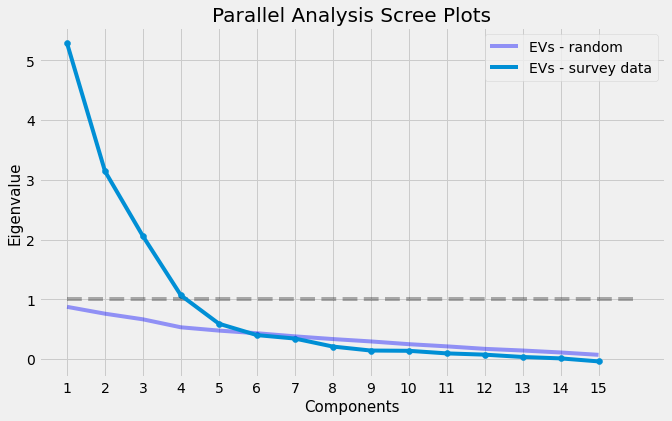

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 2 items with low main loading. Excluding them for next analysis.

Removed item tss_cre_6: It was surprising how things turned out in the story.
Main (absolute) Loading: 0.3885

Removed item tss_sty_3: The story had sentences that were unreadable
Main (absolute) Loading: 0.3695

Fitted solution #3



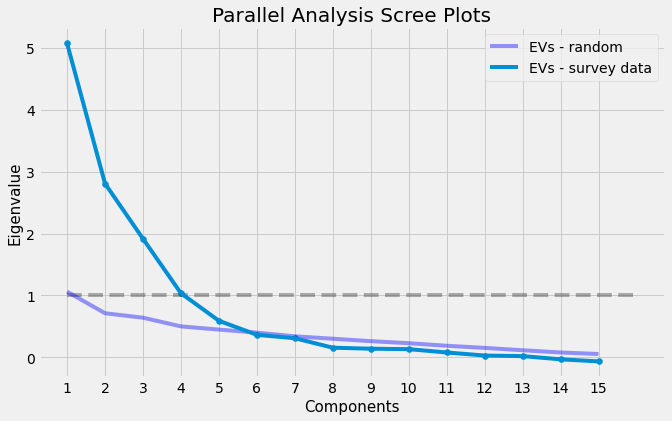

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 7 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_5: This story’s events occurred in a plausible order
Loadings: 
0    0.416619
1   -0.152802
2    0.057127
3    0.000421
4   -0.263519
Name: tss_coh_5, dtype: float64

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0   -0.456685
1    0.349574
2    0.046401
3    0.114307
4    0.131836
Name: tss_coh_9, dtype: float64

Removed item tss_cre_7: There were interesting twists and turns in the story.
Loadings: 
0    0.119957
1    0.030238
2   -0.364364
3    0.504387
4    0.011161
Name: tss_cre_7, dtype: float64

Removed item tss_qua_7: I would like to read more stories like this one.
Loadings: 
0    0.419147
1   -0.171616
2   -0.023919
3    0.436266
4    0.030303
Name: tss_qua_7, dtype: float64

Removed item t

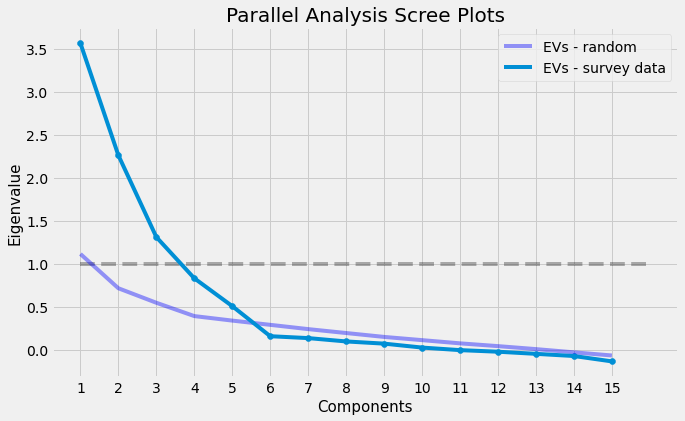

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0031178261068084802
Determinant looks good!
Overall KMO: 0.7929151924436785
All item KMOs are >.6


In [313]:
five_facs = iterative_efa(tss_df, items_analysis_li, n_facs=5, rotation_method="Oblimin", print_details=True,
                          print_par_plot=True)

In [314]:
efa_5 = five_facs[0]
items_5 = five_facs[1]

print_sorted_loadings(efa_5, items_5, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_11   0.665457                                              The story had a clear theme.
tss_pac_8    0.617000                      All elements of the story were relevant to the plot.
tss_coh_3    0.607671                                   The story appeared to be a single plot.
tss_coh_6    0.572148                                     The story felt like a coherent story.
tss_conch_8  0.546842  It was easy to understand the motivation of the characters in the story.
tss_cre_3    0.541184                        The plot development in the story was predictable.
tss_pac_7   -0.433371                  Many things seemed to be happening at once in the story. 

Relevant loadings for factor 1
                   1                                                                             descr
tss_rep_10  0.775200                            Characters said o

In [315]:
items_per_fac_5 = rev_items_and_return(tss_df, efa_5, items_5)

for factor_n in items_per_fac_5:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_5[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...

Internal consistency for factor 0:
Cronbachs alpha = 0.7868, 95% CI = [0.75, 0.82]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.7610
tss_coh_6: 0.7367
tss_coh_11: 0.7482
tss_conch_8: 0.7569
tss_cre_3: 0.7738
tss_pac_8: 0.7594
tss_pac_7_rev: 0.7788


Internal consistency for factor 1:
Cronbachs alpha = 0.7766, 95% CI = [0.73, 0.82]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.7121
tss_rep_9: 0.7024
tss_rep_10: 0.6781
tss_rep_11: 0.7878


Internal consistency for factor 2:
Cronbachs alpha = 0.6920, 95% CI = [0.63, 0.75]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6498
tss_pac_3: 0.6090
tss_pac_5: 0.5867
tss_pac_1_rev: 0.6601


Internal consistency for factor 3:
Cronbachs alpha = 0.6084, 95% CI = [0.53, 0.68]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.5315
tss_cre_12: 0.4881
tss_sty_5: 0.5660
tss_sty_9: 0.5631


Internal consistency for factor 4:


In [316]:
items_5_2 = copy.deepcopy(items_5)

items_5_2.remove("tss_rep_11")

# items_5_2.extend(["tss_rep_4", "tss_rep_5",
#                   "tss_rep_6", "tss_rep_7", "tss_rep_10", "tss_rep_12"])
items_5_2.extend(["tss_cre_1", "tss_cre_2", "tss_cre_4",
                 "tss_cre_5", "tss_cre_8", "tss_cre_10", "tss_cre_11"])
items_5_2.extend(["tss_pac_2", "tss_pac_4"])
#items_5_2.extend(["tss_sty_1", "tss_sty_2", "tss_sty_4", "tss_sty_11"])
items_5_2.extend(["tss_coh_1", "tss_coh_4", "tss_coh_12",
                  "tss_conch_1", "tss_conch_3", "tss_conch_5", "tss_conch_6"])

In [317]:
items_5_2 = reduce_multicoll(
    tss_df, items_5_2, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 9.111709979790445e-08

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_coh_12. VIF: 25.31
('The story lacked logic.')

Excluded item tss_coh_1. VIF: 20.54
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_cre_2. VIF: 19.53
('The story was boring.')

Excluded item tss_cre_5. VIF: 19.46
('The story was imaginative.')

Excluded item tss_conch_5. VIF: 16.88
('The descriptions of characters in the story were plausible.')

Excluded item tss_conch_3. VIF: 16.29
('My understanding of the characters in the story is unclear.')

Done! Determinant is now: 0.000011
I have excluded 6 redunant items with 30 items remaining


Fitted solution #1

Checking for low communalities
Detected 2 items with low communality. Excluding them for next analysis.

Removed item tss_sty_5: The story used complex vocabulary.
Communality: 0.1982

Removed item tss_sty_9: The story contained a great deal of detail.
Communality: 0.1942

Fitted solution #2



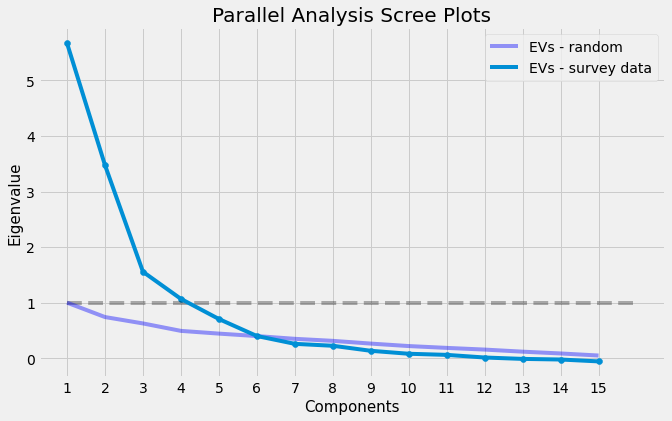

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_pac_7: Many things seemed to be happening at once in the story.
Main (absolute) Loading: 0.3662

Fitted solution #3



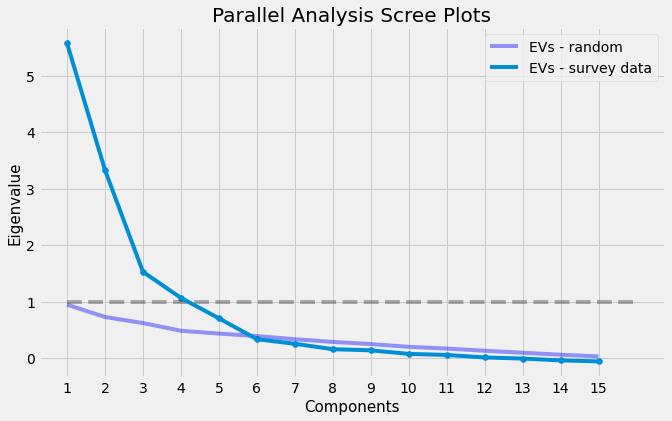

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 5 items with high cross loading. Excluding them for next analysis.

Removed item tss_cre_1: The story felt dynamic.
Loadings: 
0    0.088578
1    0.420028
2   -0.315778
3   -0.010658
4   -0.048466
Name: tss_cre_1, dtype: float64

Removed item tss_cre_8: I was intrigued by the plot.
Loadings: 
0    0.395002
1    0.519584
2   -0.098049
3    0.068507
4   -0.067893
Name: tss_cre_8, dtype: float64

Removed item tss_cre_10: The story was unconventional.
Loadings: 
0   -0.481350
1    0.532243
2    0.049114
3   -0.039858
4    0.086923
Name: tss_cre_10, dtype: float64

Removed item tss_pac_2: The story was exciting to read.
Loadings: 
0    0.343673
1    0.563209
2   -0.195959
3    0.032998
4   -0.048480
Name: tss_pac_2, dtype: float64

Removed item tss_pac_4: The story dragged on and on.
Loadings: 
0    0.002223
1   -0.022368
2    0.474048


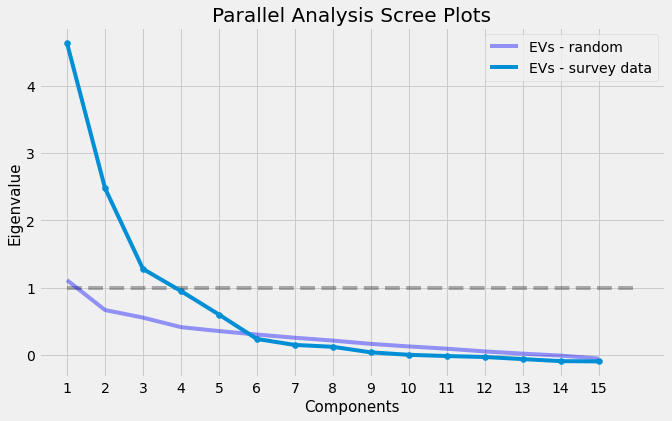

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0005012656995980562
Determinant looks good!
Overall KMO: 0.8424003713262453
All item KMOs are >.6


In [318]:
five_facs_2 = iterative_efa(tss_df, items_5_2, n_facs=5, rotation_method="Oblimin", print_details=True,
                            print_par_plot=True)

In [319]:
efa_5_2 = five_facs_2[0]
items_5_2 = five_facs_2[1]

print_sorted_loadings(efa_5_2, items_5_2, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_4    0.699068                                      The plot of the story was plausible.
tss_coh_11   0.641124                                              The story had a clear theme.
tss_coh_6    0.627916                                     The story felt like a coherent story.
tss_cre_3    0.626298                        The plot development in the story was predictable.
tss_pac_8    0.586939                      All elements of the story were relevant to the plot.
tss_conch_8  0.569366  It was easy to understand the motivation of the characters in the story.
tss_coh_3    0.560074                                   The story appeared to be a single plot.
tss_cre_11   0.536980                              The plot was typical for this kind of story.
tss_conch_6 -0.481405         The behavior of characters in the story seemed completely random. 

Relevan

In [320]:
items_per_fac_5_2 = rev_items_and_return(tss_df, efa_5_2, items_5_2)

for factor_n in items_per_fac_5_2:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_5_2[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

Internal consistency for factor 0:
Cronbachs alpha = 0.8440, 95% CI = [0.82, 0.87]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.8358
tss_coh_6: 0.8135
tss_coh_11: 0.8240
tss_conch_8: 0.8278
tss_cre_3: 0.8342
tss_pac_8: 0.8314
tss_cre_11: 0.8357
tss_coh_4: 0.8161
tss_conch_6_rev: 0.8303


Internal consistency for factor 1:
Cronbachs alpha = 0.7980, 95% CI = [0.75, 0.83]

Cronbach's alpha when excluding variable...
tss_conch_2: 0.7530
tss_conch_4: 0.6643
tss_conch_1_rev: 0.7499


Internal consistency for factor 2:
Cronbachs alpha = 0.7878, 95% CI = [0.74, 0.83]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.7396
tss_rep_9: 0.7093
tss_rep_10: 0.6864


Internal consistency for factor 3:
Cronbachs alpha = 0.7207, 95% CI = [0.66, 0.77]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.7226
tss_cre_12: 0.5689
tss_cre_4: 0.6047


Internal consistency for factor 4:
Cronbachs alpha = 0.6920, 95% CI = [0.63, 0.75]

Cronbach's alpha when excluding variable...
tss_re

In [322]:
# items_per_fac_4_2[1].remove("tss_rep_11")
# items_per_fac_4_2[2].remove("tss_cre_9")
items_per_fac_5_2

{0: ['tss_coh_3',
  'tss_coh_6',
  'tss_coh_11',
  'tss_conch_8',
  'tss_cre_3',
  'tss_pac_8',
  'tss_cre_11',
  'tss_coh_4',
  'tss_conch_6_rev'],
 1: ['tss_conch_2', 'tss_conch_4', 'tss_conch_1_rev'],
 2: ['tss_rep_3', 'tss_rep_9', 'tss_rep_10'],
 3: ['tss_cre_9', 'tss_cre_12', 'tss_cre_4'],
 4: ['tss_rep_8', 'tss_pac_3', 'tss_pac_5', 'tss_pac_1_rev']}

In [323]:
# compute scale means but only if at least 66% of questions are answered
mask_suff_data_coh = tss_df[items_per_fac_5_2[0]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[0])/3)
mask_suff_data_conch = tss_df[items_per_fac_5_2[1]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[1])/3)
mask_suff_data_rep = tss_df[items_per_fac_5_2[2]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[2])/3)
mask_suff_data_cre = tss_df[items_per_fac_5_2[3]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[3])/3)
mask_suff_data_pac = tss_df[items_per_fac_5_2[4]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[4])/3)

tss_df["tss_coh"] = tss_df[mask_suff_data_coh][items_per_fac_5_2[0]].mean(
    axis=1)
tss_df["tss_conch"] = tss_df[mask_suff_data_cre][items_per_fac_5_2[1]].mean(
    axis=1)
tss_df["tss_rep"] = tss_df[mask_suff_data_rep][items_per_fac_5_2[2]].mean(
    axis=1)
tss_df["tss_cre"] = tss_df[mask_suff_data_cre][items_per_fac_5_2[3]].mean(
    axis=1)
tss_df["tss_pac"] = tss_df[mask_suff_data_pac][items_per_fac_5_2[4]].mean(
    axis=1)

# Some scales might make more sense fully reversed
tss_df["tss_pac"] = (tss_df["tss_pac"]-6)*-1
tss_df["tss_conch"] = (tss_df["tss_conch"]-6)*-1
tss_df["tss_avoid_rep"] = (tss_df["tss_rep"]-6)*-1

In [324]:
# if you actually have missing data, double check if this worked as intended
tss_df[~mask_suff_data_cre]

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,tss_pac_7_rev,tss_pac_1_rev,tss_conch_6_rev,tss_conch_1_rev,tss_coh,tss_conch,tss_rep,tss_cre,tss_pac,tss_avoid_rep


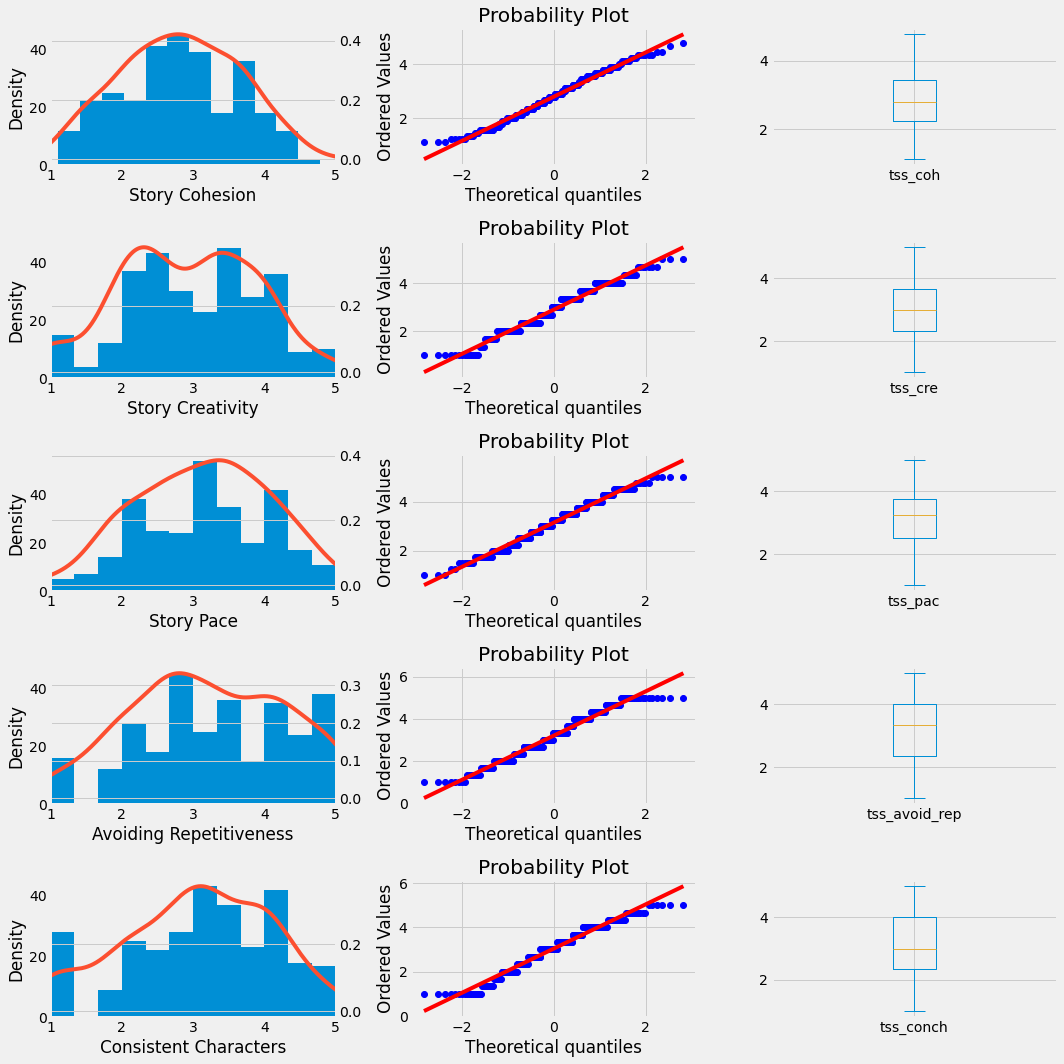

In [325]:
# Check scale distributions
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

# Histograms with KDE
ax1 = tss_df["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
ax1.set_xlim(1, 5)
tss_df["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = tss_df["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
ax2.set_xlim(1, 5)
tss_df["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = tss_df["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
tss_df["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")
ax3.set_xlim(1, 5)

ax4 = tss_df["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
tss_df["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Avoiding Repetitiveness")
ax4.set_xlim(1, 5)

ax5 = tss_df["tss_conch"].plot.hist(ax=axes[4, 0], bins=12)
tss_df["tss_conch"].plot.kde(ax=axes[4, 0], secondary_y=True)
ax5.set_xlabel("Consistent Characters")
ax5.set_xlim(1, 5)

# Q-Q Plots
stats.probplot(tss_df["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(tss_df["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(tss_df["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(tss_df["tss_avoid_rep"], dist="norm", plot=axes[3, 1])
stats.probplot(tss_df["tss_conch"], dist="norm", plot=axes[4, 1])

# Boxplots
tss_df["tss_coh"].plot.box(ax=axes[0, 2])
tss_df["tss_cre"].plot.box(ax=axes[1, 2])
tss_df["tss_pac"].plot.box(ax=axes[2, 2])
tss_df["tss_avoid_rep"].plot.box(ax=axes[3, 2])
tss_df["tss_conch"].plot.box(ax=axes[4, 2])

fig.tight_layout()
plt.show()

In [326]:
tss_df[["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]].corr()

,tss_coh,tss_cre,tss_avoid_rep,tss_pac,tss_conch
tss_coh,1.000000,0.123771,0.151682,-0.030950,0.455914
tss_cre,0.123771,1.000000,0.177906,0.284705,0.239640
tss_avoid_rep,0.151682,0.177906,1.000000,0.239921,0.189581
tss_pac,-0.030950,0.284705,0.239921,1.000000,0.020868
tss_conch,0.455914,0.239640,0.189581,0.020868,1.000000


<Figure size 720x720 with 0 Axes>

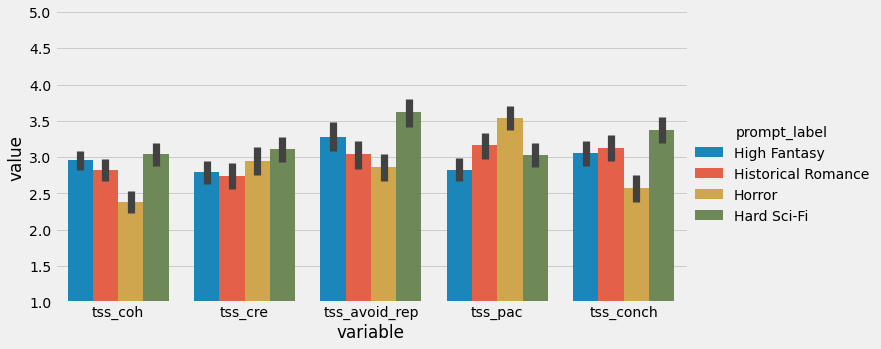

In [327]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "prompt_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<Figure size 720x720 with 0 Axes>

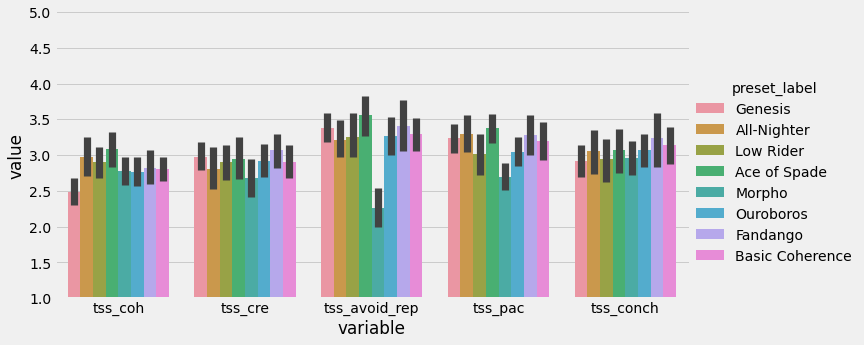

In [328]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "preset_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<AxesSubplot:xlabel='word_count', ylabel='tss_conch'>

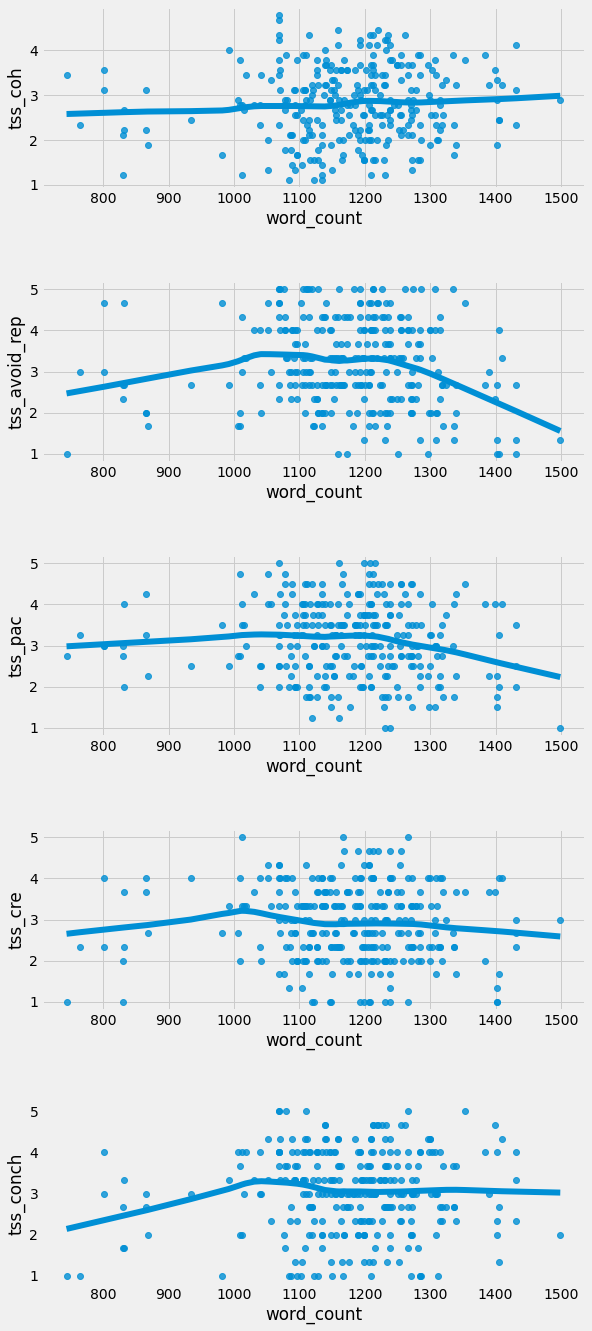

In [329]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_df, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0])
sns.regplot(data=tss_df, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[1])
sns.regplot(data=tss_df, y="tss_pac",
            x="word_count", lowess=True, ax=axes[2])
sns.regplot(data=tss_df, y="tss_cre",
            x="word_count", lowess=True, ax=axes[3])
sns.regplot(data=tss_df, y="tss_conch",
            x="word_count", lowess=True, ax=axes[4])

In [330]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["words_cent"] = tss_df["word_count"].apply(
    lambda x: x-tss_df["word_count"].mean())  # centering

tss_df["words_cent**2"] = tss_df["words_cent"]*tss_df["words_cent"]
tss_df["words_cent**3"] = tss_df["words_cent"]**3
#tss_df["words_cent**4"] = tss_df["words_cent"]**4
#tss_df["words_cent**5"] = tss_df["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA

Model performance for linear model predicting tss_coh:
r-square: -0.0149    RMSE: 0.8115
Model performance for quadratic model predicting tss_coh:
r-square: -0.0158    RMSE: 0.8119
Model performance for cubic model predicting tss_coh:
r-square: -0.0238    RMSE: 0.8150

Model performance for linear model predicting tss_cre:
r-square: -0.0259    RMSE: 0.9276
Model performance for quadratic model predicting tss_cre:
r-square: -0.0378    RMSE: 0.9321
Model performance for cubic model predicting tss_cre:
r-square: -0.0330    RMSE: 0.9297

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0146    RMSE: 1.0487
Model performance for quadratic model predicting tss_avoid_rep:
r-square: 0.0414    RMSE: 1.0181
Model performance for cubic model predicting tss_avoid_rep:
r-square: 0.0381    RMSE: 1.0201

Model performance for linear model predicting tss_pac:
r-square: -0.0488    RMSE: 0.8985
Model performance for quadratic model predicting tss_pac:
r-square: -0.0297    RMSE: 

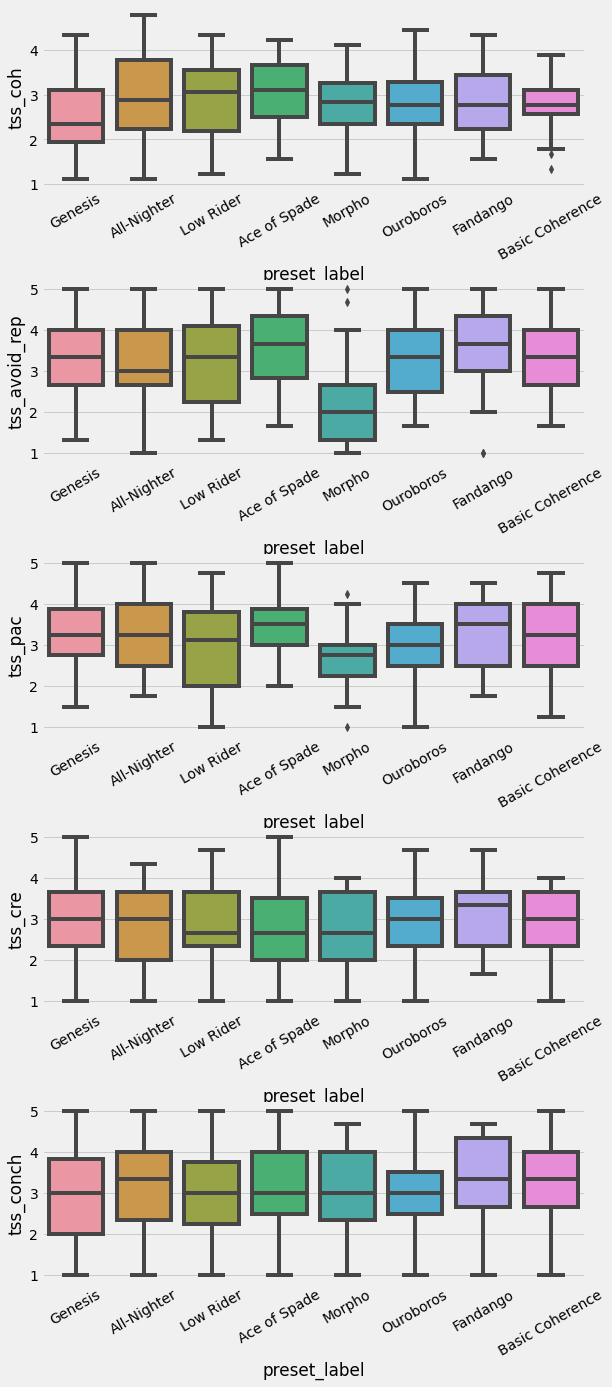

In [331]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

sns.boxplot(x="preset_label", y="tss_coh", data=tss_df, ax=axes[0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=tss_df, ax=axes[1])
sns.boxplot(x="preset_label", y="tss_pac", data=tss_df, ax=axes[2])
sns.boxplot(x="preset_label", y="tss_cre", data=tss_df, ax=axes[3])
sns.boxplot(x="preset_label", y="tss_conch", data=tss_df, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

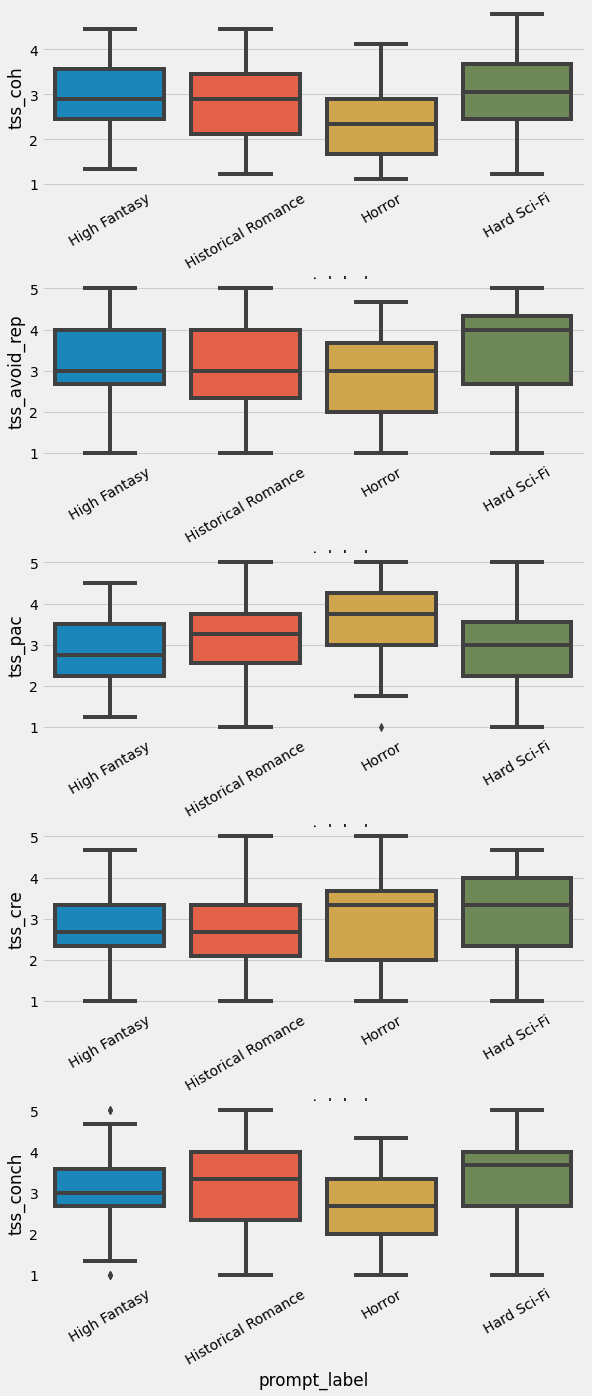

In [332]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=tss_df, ax=axes[0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=tss_df, ax=axes[1])
sns.boxplot(x="prompt_label", y="tss_pac", data=tss_df, ax=axes[2])
sns.boxplot(x="prompt_label", y="tss_cre", data=tss_df, ax=axes[3])
sns.boxplot(x="prompt_label", y="tss_conch", data=tss_df, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [333]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)

    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(
            q1, q3, iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")

In [370]:
# Outliers for Presets

# # Outliers Coherence
print("Exterme outliers on tss_coh, Basic Coherence preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Basic Coherence"], "tss_coh")

# Outliers Repitition
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_avoid_rep")
print("\nExterme outliers on tss_rep, Fandango preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Fandango"], "tss_avoid_rep")

# Outliers pace
print("\nExterme outliers on tss_pac, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_pac")

# Outliers creativity
# print("\nExterme outliers on tss_cre, Low Rider preset")
# determine_outliers(tss_df[tss_df["preset_label"] == "Low Rider"], "tss_cre")
# print("\nExterme outliers on tss_pac, Ouroboros preset")
# determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_cre")

# Outliers for Prompts

# # Coherence
# print("\nExterme outliers on tss_coh, Hard Sci-Fi prompt")
# determine_outliers(tss_df[tss_df["prompt_label"] == "Hard Sci-Fi"], "tss_coh")

# Pace
print("\nExterme outliers on tss_pac, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_pac")

# # Creativity
# print("\nExterme outliers on tss_cre, Horror prompt")
# determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_cre")

Exterme outliers on tss_coh, Basic Coherence preset
25th Percentile (Q1): 2.56
75th Percentile (Q3): 3.11
IQR: 0.56
Will count cases as outlier with values less than 0.89 or more than 4.78.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Morpho preset
25th Percentile (Q1): 1.33
75th Percentile (Q3): 2.67
IQR: 1.33
Will count cases as outlier with values less than -2.67 or more than 6.67.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Fandango preset
25th Percentile (Q1): 3.00
75th Percentile (Q3): 4.33
IQR: 1.33
Will count cases as outlier with values less than -1.00 or more than 8.33.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Morpho preset
25th Percentile (Q1): 2.25
75th Percentile (Q3): 3.00
IQR: 0.75
Will count cases as outlier with values less than 0.00 or more than 5.25.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Horror prompt
25th

In [371]:
#tss_no_out = tss_df[~(tss_df.index == 7)].copy()
tss_no_out = tss_df

In [372]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15, 15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(groups_li), len(vars_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li, vars_li):
        stats.probplot(df[df[group_label] == group][var],
                       dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - " + var)
        if x < (len(vars_li)-1):
            x += 1
        else:
            x = 0
            y += 1

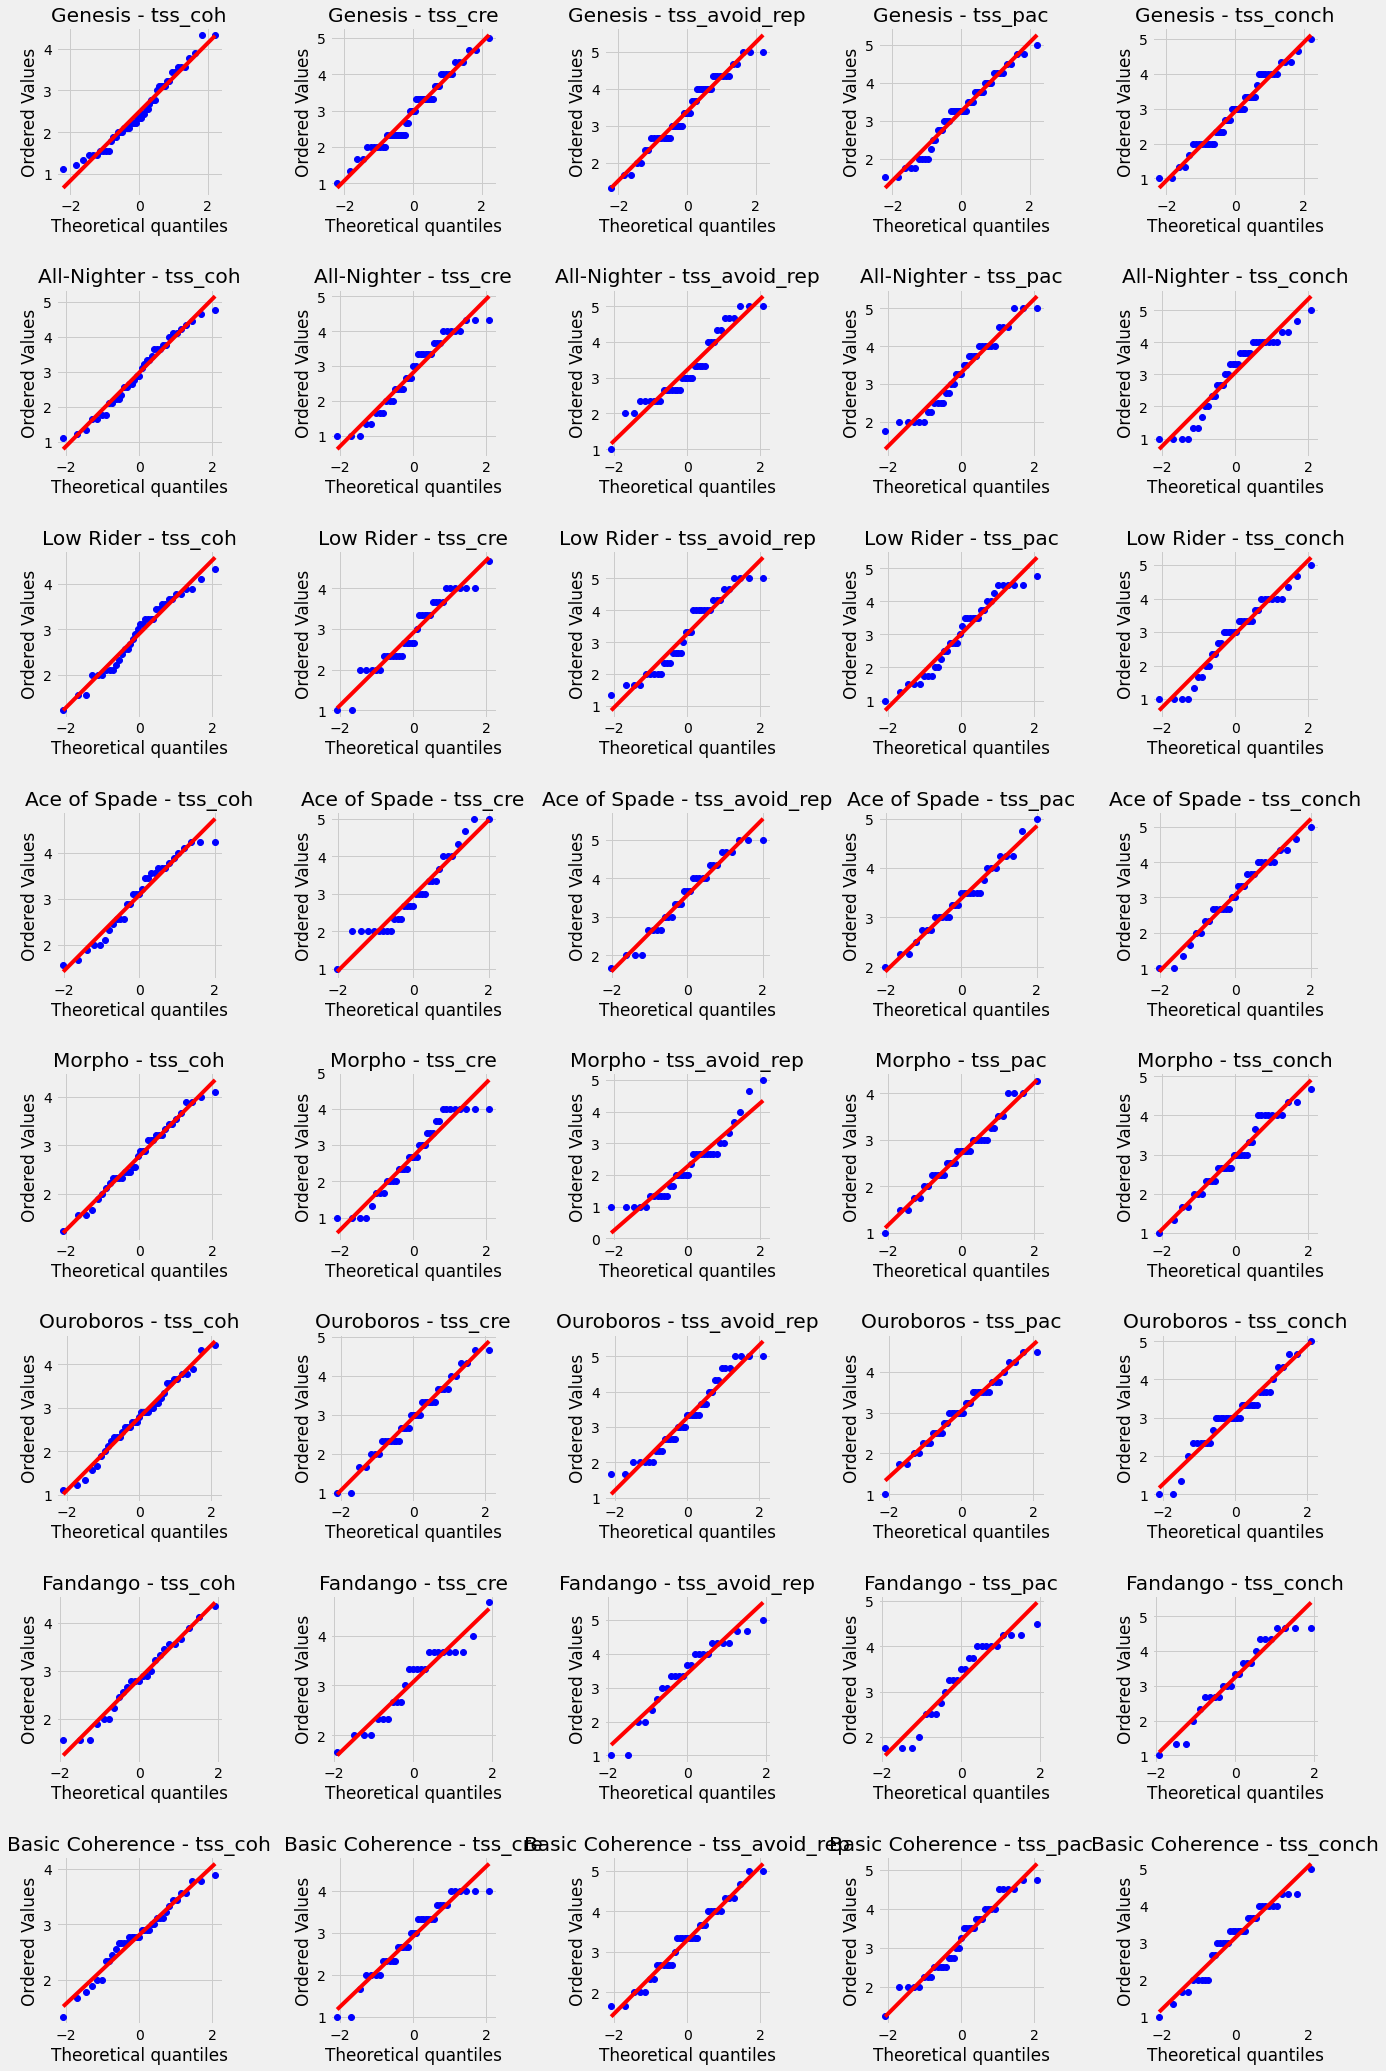

In [373]:
qqs_over_groups_and_vars(tss_no_out, "preset_label", outcome_li, size=(20, 30))

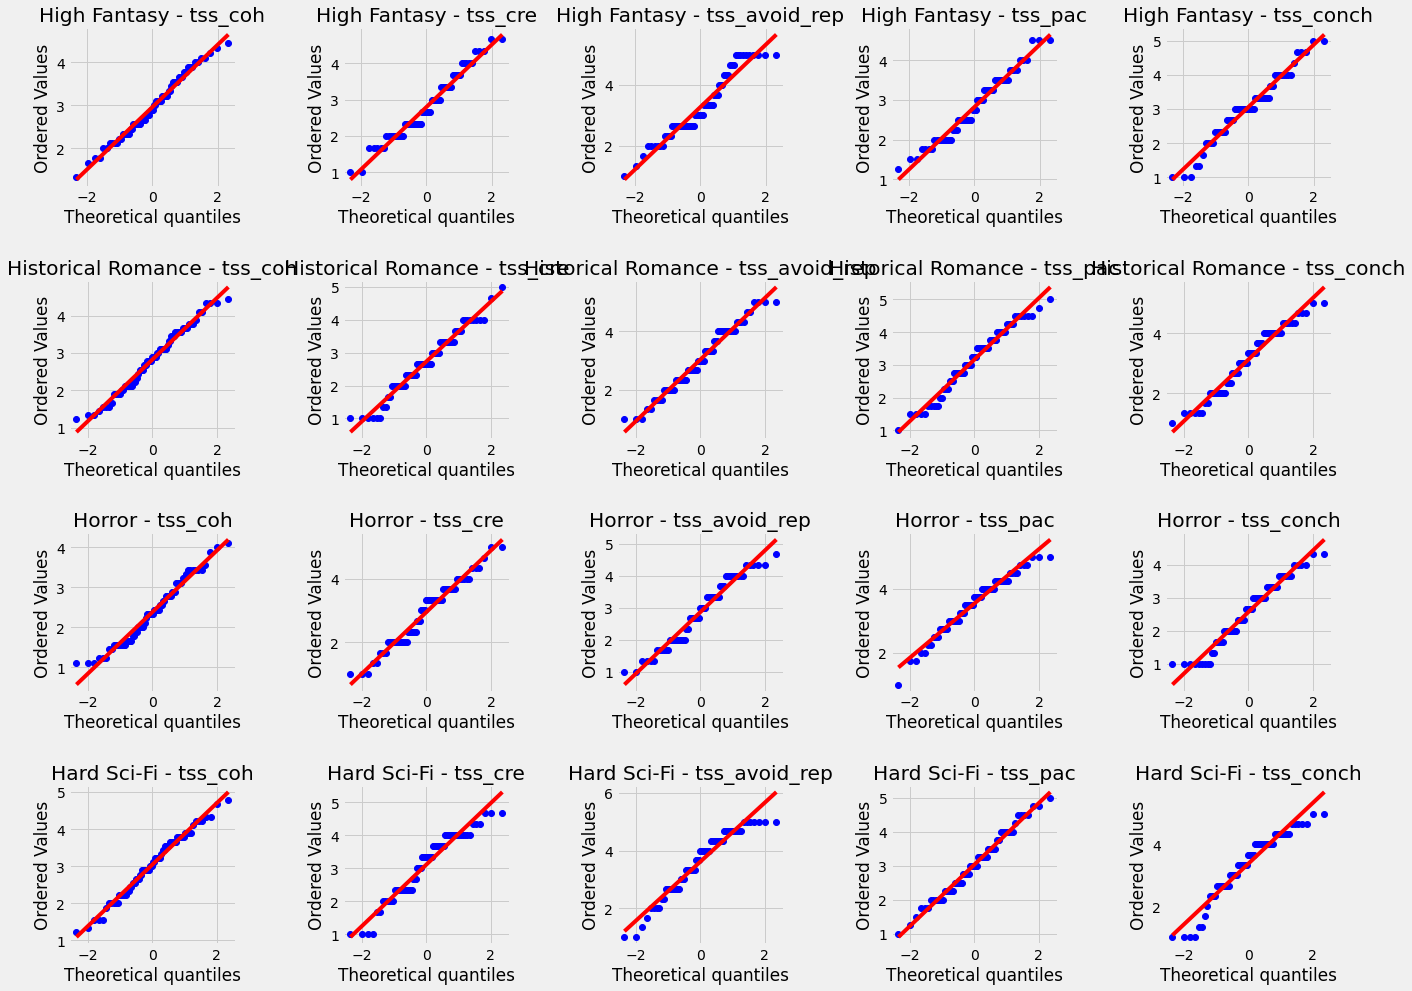

In [374]:
qqs_over_groups_and_vars(tss_no_out, "prompt_label", outcome_li, size=(20, 15))

In [379]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {:.2f}, coefficient of sample size variation is {:.2f}, variance ratio is {:.2f}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")

In [380]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_no_out)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_no_out)
    print("\n")

Checks for tss_coh
Preset
Smallest variance for Basic Coherence: 0.37
Largest variance for All-Nighter: 1.05
Variance ratio for: 2.86
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is 0.05. That is between 0 and .5. F-test should be robust

Prompt
Smallest variance for High Fantasy: 0.51
Largest variance for Hard Sci-Fi: 0.67
Variance ratio for: 1.31
Variance ratio is smaller or equal to 1.5, F-test will be robust.


Checks for tss_cre
Preset
Smallest variance for Fandango: 0.57
Largest variance for All-Nighter: 1.08
Variance ratio for: 1.89
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is 0.31. That is between 0 and .5. F-test should be robust

Prompt
Smallest variance for High Fantasy: 0.73
Largest variance for Horror: 0.94
Variance ratio for: 1.30
Variance ratio is smaller or equal to 1.5, F-test 

In [381]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_no_out).fit()
    anova_mod2 = ols(
        ols_formula2, tss_no_out).fit()
    print(sm.stats.anova_lm(anova_mod, typ=2))
    print(anova_mod.summary(alpha=0.1))

    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")

    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7],
                  outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]

    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10],
                  outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]

tss_coh
                             sum_sq     df          F    PR(>F)
C(preset_label, Sum)       8.347826    7.0   1.994959  0.055840
C(prompt_label, Sum)      18.483312    3.0  10.306640  0.000002
C(sample, Treatment(0))    0.076732    1.0   0.128362  0.720407
Residual                 167.378420  280.0        NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                tss_coh   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     4.180
Date:                Sat, 09 Apr 2022   Prob (F-statistic):           9.82e-06
Time:                        12:33:34   Log-Likelihood:                -333.08
No. Observations:                 292   AIC:                             690.2
Df Residuals:                     280   BIC:                             734.3
Df Model:                          11   

                             sum_sq     df         F    PR(>F)
C(preset_label, Sum)      11.227832    7.0  2.244811  0.030931
C(prompt_label, Sum)      19.613208    3.0  9.149752  0.000009
C(sample, Treatment(0))    5.180547    1.0  7.250327  0.007516
Residual                 200.067281  280.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                tss_pac   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     4.635
Date:                Sat, 09 Apr 2022   Prob (F-statistic):           1.69e-06
Time:                        12:33:35   Log-Likelihood:                -359.13
No. Observations:                 292   AIC:                             742.3
Df Residuals:                     280   BIC:                             786.4
Df Model:                          11                

In [382]:
params_df.index = params_df.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - \
        params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace(
    "90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_no_out["preset_label"].unique())
prompts_li = list(tss_no_out["prompt_label"].unique())

order_index = ["Intercept"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]

    cols_order.extend([outcome, outcome + " p-value",
                       outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]

In [383]:
params_df

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin,tss_conch,tss_conch p-value,tss_conch adj_p,tss_conch 90% CI margin
Intercept,2.807177,9.088976e-127,NaN,0.106315,2.795026,3.034387e-108,NaN,0.126628,3.388798,1.885761e-125,NaN,0.129949,3.275255,1.021049e-133,NaN,0.116234,2.944276,6.523602e-108,NaN,0.133832
Genesis,-0.320042,2.497142e-03,0.019977,0.173097,0.095246,4.464558e-01,0.996983,0.206170,0.207395,1.068530e-01,2.849413e-01,0.211576,0.097197,3.973837e-01,0.529845,0.189246,-0.088523,5.031197e-01,0.875986,0.217899
All-Nighter,0.116620,3.305988e-01,0.809518,0.197475,-0.091180,5.228515e-01,0.996983,0.235206,-0.057189,6.960894e-01,6.994629e-01,0.241374,0.170557,1.933982e-01,0.515729,0.215899,-0.027765,8.538926e-01,0.875986,0.248587
Low Rider,0.087529,4.695009e-01,0.809518,0.199441,0.007262,9.598010e-01,0.996983,0.237547,0.057083,6.994629e-01,6.994629e-01,0.243777,-0.145880,2.704955e-01,0.529845,0.218048,-0.076698,6.145450e-01,0.875986,0.251061
Ace of Spade,0.266780,3.936382e-02,0.157455,0.212685,0.048154,7.539766e-01,0.996983,0.253322,0.368178,2.013019e-02,8.052075e-02,0.259966,0.213125,1.315086e-01,0.515729,0.232528,0.025341,8.759863e-01,0.875986,0.267734
Morpho,-0.062236,6.071384e-01,0.809518,0.199534,-0.200393,1.651674e-01,0.996983,0.237659,-0.935295,9.774871e-10,7.819896e-09,0.243891,-0.431784,1.224589e-03,0.009797,0.218150,-0.085407,5.751462e-01,0.875986,0.251179
Ouroboros,-0.060697,6.039843e-01,0.809518,0.192905,0.000527,9.969826e-01,0.996983,0.229762,0.064872,6.501475e-01,6.994629e-01,0.235788,-0.081880,5.222322e-01,0.596837,0.210902,0.023053,8.756178e-01,0.875986,0.242834
Fandango,-0.030361,8.315430e-01,0.950335,0.235324,0.122508,4.713121e-01,0.996983,0.280287,0.167081,3.385759e-01,6.114216e-01,0.287637,0.144646,3.542960e-01,0.529845,0.257279,0.121015,5.007570e-01,0.875986,0.296232
Basic Coherence,0.002407,9.839454e-01,0.983945,0.197240,0.017875,9.001610e-01,0.996983,0.234926,0.127875,3.821385e-01,6.114216e-01,0.241087,0.034020,7.947800e-01,0.794780,0.215642,0.108984,4.694342e-01,0.875986,0.248291
High Fantasy,0.174462,3.005778e-02,0.040077,0.132045,-0.100549,2.923004e-01,0.389734,0.157275,0.111336,2.559200e-01,2.559200e-01,0.161399,-0.298889,7.276947e-04,0.001455,0.144365,0.034048,7.355889e-01,0.735589,0.166222


In [384]:
adj_p_cols = params_df.columns.str.extractall("(.*adj_p)").values.flatten()
mask_sig = (params_df[adj_p_cols] < 0.1).any(axis=1)

params_df[mask_sig]

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin,tss_conch,tss_conch p-value,tss_conch adj_p,tss_conch 90% CI margin
Genesis,-0.320042,2.497142e-03,0.019977,0.173097,0.095246,0.446456,0.996983,0.206170,0.207395,1.068530e-01,2.849413e-01,0.211576,0.097197,0.397384,0.529845,0.189246,-0.088523,0.503120,0.875986,0.217899
Ace of Spade,0.266780,3.936382e-02,0.157455,0.212685,0.048154,0.753977,0.996983,0.253322,0.368178,2.013019e-02,8.052075e-02,0.259966,0.213125,0.131509,0.515729,0.232528,0.025341,0.875986,0.875986,0.267734
Morpho,-0.062236,6.071384e-01,0.809518,0.199534,-0.200393,0.165167,0.996983,0.237659,-0.935295,9.774871e-10,7.819896e-09,0.243891,-0.431784,0.001225,0.009797,0.218150,-0.085407,0.575146,0.875986,0.251179
High Fantasy,0.174462,3.005778e-02,0.040077,0.132045,-0.100549,0.292300,0.389734,0.157275,0.111336,2.559200e-01,2.559200e-01,0.161399,-0.298889,0.000728,0.001455,0.144365,0.034048,0.735589,0.735589,0.166222
Horror,-0.416511,2.674084e-07,0.000001,0.130332,0.041048,0.662896,0.662896,0.155235,-0.348536,3.618434e-04,7.236869e-04,0.159306,0.409467,0.000003,0.000013,0.142492,-0.464571,0.000005,0.000018,0.164066
Hard Sci-Fi,0.229379,3.615594e-03,0.007231,0.128991,0.223777,0.016878,0.067514,0.153637,0.391146,5.548455e-05,2.219382e-04,0.157666,-0.132955,0.120868,0.161157,0.141025,0.346362,0.000503,0.001006,0.162377


In [385]:
tss_no_out["preset_label"].value_counts()

Genesis            51
Ouroboros          39
All-Nighter        37
Basic Coherence    37
Low Rider          36
Morpho             36
Ace of Spade       31
Fandango           25
Name: preset_label, dtype: int64

In [346]:
# labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# # create dicts with a key for each preset with an empty list as value for each
# marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
# yerr_dict = {preset: [] for preset in params_df[1:8].index}
# #colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

# for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
#     marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
#     yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

# figure = plt.figure(figsize=(10, 5))

# x = np.arange(len(labels)) # label locations
# width = 0.35 # width of bars

# plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
#         yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")
# plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
#         yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")


# i = 0
# pos = -0.4
# for outcome in outcome_li:
#     grand_mean = params_df.loc["Intercept", outcome]
#     ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
#     if i == 0:
#         ax[0].set_label("Grand Mean (all Presets)")
#     i += 1
#     pos += 1

# plt.ylim(1,5)
# plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
# plt.xticks(x, labels, fontsize = 16)

# plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
# leg = plt.gca().get_legend()
# plt.grid(False)
# #plt.title("Genesis & Low Rider")
# #figure.tight_layout()
# plt.show()

# figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")

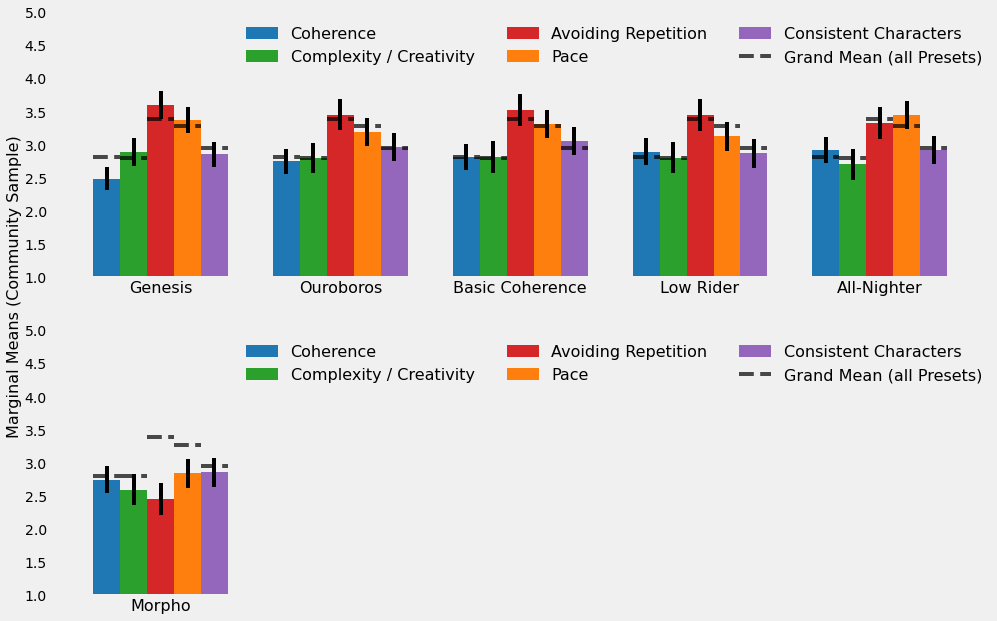

In [386]:
labels = ["Coherence", "Complexity / Creativity",
          "Avoiding Repitition", "Pace", "Consistent Characters"]
presets_1 = ["Genesis", "Ouroboros",
             "Basic Coherence", "Low Rider", "All-Nighter"]
presets_2 = ["Morpho"]

preset_to_graph = [presets_1, presets_2]

max_n_presets = max([len(x) for x in preset_to_graph])

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# fig.tight_layout(pad=5.0)
plt.setp(axes, ylim=(1, 5))
fig.text(0.04, 0.5, "Marginal Means (Community Sample)",
         va='center', rotation='vertical', fontsize=16)

i = 0
for pre_li in preset_to_graph:

    # create dicts with a key for each outcome with an empty list as value for each
    marginal_means_dict = {outcome: [] for outcome in outcome_li}
    yerr_dict = {outcome: [] for outcome in outcome_li}

    prod_presets_outcomes = itertools.product(pre_li, outcome_li)

    for preset, outcome in prod_presets_outcomes:
        marginal_means_dict[outcome].append(
            params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
        yerr_dict[outcome].append(
            params_df.loc[preset, outcome + " 90% CI margin"])

    # Compute difference in length to longest row
    diff_len = max_n_presets - len(pre_li)

    # fill up dictonaries with 0 if less values than the longest row
    if diff_len > 0:
        for outcome in outcome_li:
            marginal_means_dict[outcome].extend([0]*diff_len)
            yerr_dict[outcome].extend([0]*diff_len)

    x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
    width = 0.15  # width of bars

    cur_ax = axes[i]
    n_presets = len(pre_li)

    x_labels = pre_li
    x_labels.extend([""]*diff_len)

    cur_ax.set_xticks(x)
    cur_ax.set_xticklabels(x_labels, fontsize=16)

    cur_ax.bar(x-0.3, marginal_means_dict["tss_coh"], width,
               yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

    cur_ax.bar(x-0.15, marginal_means_dict["tss_cre"], width,
               yerr=yerr_dict["tss_cre"], label="Complexity / Creativity", color="tab:green")

    cur_ax.bar(x, marginal_means_dict["tss_avoid_rep"], width,
               yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

    cur_ax.bar(x+0.15, marginal_means_dict["tss_pac"], width,
               yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

    cur_ax.bar(x+0.3, marginal_means_dict["tss_conch"], width,
               yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

    outcome_i = 0
    pos = -0.375
    for outcome in outcome_li:
        grand_mean = params_df.loc["Intercept", outcome]
        for preset_i in range(0, n_presets):
            ax = cur_ax.plot([pos+preset_i, pos+width+preset_i],
                             [grand_mean, grand_mean], '--', color="black", alpha=0.7)
        if outcome_i == 0:
            ax[0].set_label("Grand Mean (all Presets)")
        outcome_i += 1
        pos += width

    handles, labels = cur_ax.get_legend_handles_labels()
    order = [1, 2, 3, 4, 5, 0]
    cur_ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.6, 1))
    cur_ax.grid(False)

    i += 1

plt.show()

figure.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")

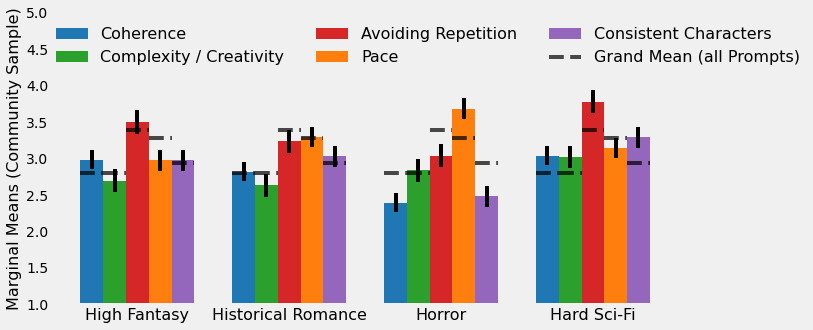

In [387]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}

for prompt, outcome in itertools.product(prompts_li, outcome_li):
    marginal_means_dict[outcome].append(
        params_df.loc["Intercept", outcome] + params_df.loc[prompt, outcome])
    yerr_dict[outcome].append(
        params_df.loc[prompt, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.15  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.15, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Complexity / Creativity", color="tab:green")

plt.bar(x, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.15, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.bar(x+0.3, marginal_means_dict["tss_conch"], width,
        yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts_li, fontsize=16)

outcome_i = 0
pos = -0.375
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    for preset_i in range(0, len(plt.gca().get_xticks())):
        ax = plt.plot([pos+preset_i, pos+width+preset_i],
                      [grand_mean, grand_mean], '--', color="black", alpha=0.7)
    if outcome_i == 0:
        ax[0].set_label("Grand Mean (all Prompts)")
    outcome_i += 1
    pos += width


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 5, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")

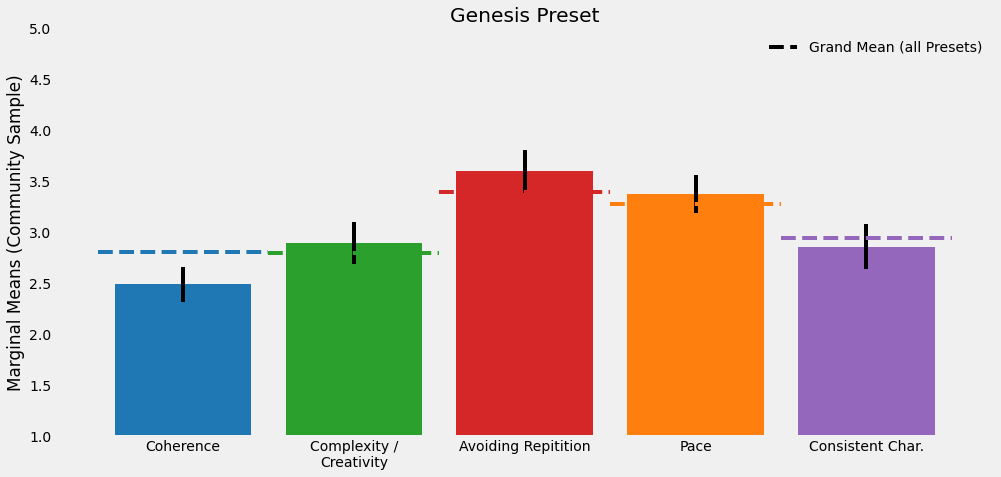

In [388]:
genesis_marginal_means = []
genesis_yerr = []
colors = ["tab:blue", "tab:green", "tab:red", "tab:orange", "tab:purple"]

for outcome in outcome_li:
    genesis_marginal_means.append(
        params_df.loc["Intercept", outcome] + params_df.loc["Genesis", outcome])
    genesis_yerr.append(params_df.loc["Genesis", outcome + " 90% CI margin"])


figure = plt.figure(figsize=(15, 7))

plt.bar(["Coherence", "Complexity /\nCreativity", "Avoiding Repitition", "Pace", "Consistent Char."],
        genesis_marginal_means, yerr=genesis_yerr,
        color=colors)

i = 0
pos = -0.5
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+1], [grand_mean, grand_mean],
                  '--', color=colors[i])
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)")

plt.legend(frameon=False)
leg = plt.gca().get_legend()
leg.legendHandles[0].set_color('black')
plt.grid(False)
plt.title("Genesis Preset")
plt.show()
figure.savefig('graphs/genesis.png', bbox_inches="tight")

In [389]:
for outcome in outcome_li:
    print("___________________________________________________\n")
    print("\033[1m{}\033[0m".format(outcome))

    homo_res = pg.homoscedasticity(
        tss_no_out, dv=outcome, group="preset_label", method="levene", alpha=0.1)
    print("Omnibus Test for homoscedasticity across presets")
    print(homo_res.round(3))

    if homo_res.iloc[0, 2] == False:
        print("\nVariances are not equal, doing posthoc tests")
        print(f"Average SD: {tss_no_out[outcome].std():.2f}")
        print("\nPresets with adjusted p-vals < .15 displayed below:")
        
        posthoc_dict = {}
        for preset in presets_li:
            data_preset = tss_no_out[tss_no_out["preset_label"]
                                     == preset][outcome].to_numpy()
            data_rest = tss_no_out[tss_no_out["preset_label"]
                                   != preset][outcome].to_numpy()
            posthoc_dict[preset] = pg.homoscedasticity(
                [data_preset, data_rest], method="levene", alpha=0.1)

        ps_li = []
        for dv in posthoc_dict:
            ps_li.append(posthoc_dict[dv].iloc[0, 1])
        adj_ps_li = fdrcorrection(ps_li, alpha=0.1)[1]

        i = 0
        for dv in posthoc_dict:
            posthoc_dict[dv].loc["levene", "sd"] = tss_no_out[tss_no_out["preset_label"] == dv][outcome].std()
            posthoc_dict[dv].loc["levene", "adj_p"] = adj_ps_li[i]
            if posthoc_dict[dv].loc["levene", "adj_p"] < 0.15:
                print(f"\n{dv}")
                print(posthoc_dict[dv].round(3))
            i += 1

    homo_res = pg.homoscedasticity(
        tss_no_out, dv=outcome, group="prompt_label", method="levene", alpha=0.1)
    print("--------------------------------------------------")
    print("\nOmnibus Test for homoscedasticity across prompts")
    print(f"{homo_res.round(3)}\n")

___________________________________________________

tss_coh
Omnibus Test for homoscedasticity across presets
            W   pval  equal_var
levene  2.145  0.039      False

Variances are not equal, doing posthoc tests
Average SD: 0.82

Presets with adjusted p-vals < .15 displayed below:

All-Nighter
            W   pval  equal_var     sd  adj_p
levene  7.477  0.007      False  1.024  0.027

Basic Coherence
             W   pval  equal_var     sd  adj_p
levene  10.186  0.002      False  0.606  0.013
--------------------------------------------------

Omnibus Test for homoscedasticity across prompts
            W   pval  equal_var
levene  0.529  0.663       True

___________________________________________________

tss_cre
Omnibus Test for homoscedasticity across presets
            W   pval  equal_var
levene  0.914  0.496       True
--------------------------------------------------

Omnibus Test for homoscedasticity across prompts
            W   pval  equal_var
levene  0.673  0.569 

In [390]:
tss_no_out[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre", "tss_conch",
            "tss_cre_4",
            "tss_qua_1", "tss_qua_2", "tss_qua_3", "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]].corr(method="kendall")

,tss_coh,tss_avoid_rep,tss_pac,tss_cre,tss_conch,tss_cre_4,tss_qua_1,tss_qua_2,tss_qua_3,tss_qua_5,tss_qua_6,tss_qua_7,tss_qua_8
tss_coh,1.000000,0.098540,-0.033750,0.098296,0.347539,0.078232,0.372222,0.408246,0.326012,0.261117,0.427124,0.369191,0.412083
tss_avoid_rep,0.098540,1.000000,0.188866,0.118225,0.153930,0.137155,0.200688,0.198047,0.179794,0.163021,0.159463,0.192300,0.199412
tss_pac,-0.033750,0.188866,1.000000,0.194820,0.011830,0.254000,0.182728,0.090688,0.249102,0.186781,0.133391,0.123347,0.057572
tss_cre,0.098296,0.118225,0.194820,1.000000,0.156025,0.697384,0.361244,0.339448,0.373762,0.384529,0.400167,0.348125,0.320837
tss_conch,0.347539,0.153930,0.011830,0.156025,1.000000,0.186403,0.245060,0.282638,0.211484,0.232459,0.256098,0.163192,0.270091
tss_cre_4,0.078232,0.137155,0.254000,0.697384,0.186403,1.000000,0.381031,0.304997,0.398313,0.370182,0.370401,0.305487,0.302702
tss_qua_1,0.372222,0.200688,0.182728,0.361244,0.245060,0.381031,1.000000,0.523011,0.710476,0.404616,0.704884,0.599563,0.510880
tss_qua_2,0.408246,0.198047,0.090688,0.339448,0.282638,0.304997,0.523011,1.000000,0.514539,0.465390,0.593696,0.576666,0.669382
tss_qua_3,0.326012,0.179794,0.249102,0.373762,0.211484,0.398313,0.710476,0.514539,1.000000,0.423065,0.717929,0.608764,0.514326
tss_qua_5,0.261117,0.163021,0.186781,0.384529,0.232459,0.370182,0.404616,0.465390,0.423065,1.000000,0.386340,0.381886,0.438544


In [354]:
items_descr[["tss_cre_4", "tss_qua_1", "tss_qua_2", "tss_qua_3",
             "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]

item_label
tss_cre_4                             The story was creative.
tss_qua_1                           This story was enjoyable.
tss_qua_2                      This story is of high quality.
tss_qua_3                          The story was fun to read.
tss_qua_5                               The story felt vivid.
tss_qua_6                                 I liked this story.
tss_qua_7    I would like to read more stories like this one.
tss_qua_8                         The story was well-written.
Name: item description, dtype: object

In [355]:
tss_no_out["qual_2_agree+"] = tss_no_out["tss_qua_2"].apply(
    lambda x: 1 if x >= 4 else 0)
tss_no_out["qual_1_agree+"] = tss_no_out["tss_qua_1"].apply(
    lambda x: 1 if x >= 4 else 0)

In [356]:
# Center preds and prepare polynomial arrays
unc_pred_names_li = ["word_count", "tss_coh",
                     "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
cent_pred_names_li = []

# Defining predictors for models
for pred in unc_pred_names_li:
    cent_pred = pred + "_cent"
    tss_no_out[cent_pred] = tss_no_out[pred].apply(
        lambda x: x-tss_no_out[pred].mean())  # centering
    cent_pred_names_li.append(cent_pred)

lin_pred_data = tss_no_out[cent_pred_names_li].to_numpy()

poly_lin = polyfeat(interaction_only=True, include_bias=False)
lin_int_pred_data = poly_lin.fit_transform(lin_pred_data)

quad_pred_data = np.hstack((lin_pred_data, lin_pred_data**2))
cub_pred_data = np.hstack((lin_pred_data, lin_pred_data**2, lin_pred_data**3))
quart_pred_data = np.hstack(
    (lin_pred_data, lin_pred_data**2, lin_pred_data**3, lin_pred_data**4))

# Setting up k-fold cross validation
kf = KFold(10, shuffle=True, random_state=42)

log_model = logreg(max_iter=1000)

# setup list of model names with predictor arrays
poly_preds_li = [("linear", lin_pred_data), ("linear with interactions", lin_int_pred_data),
                 ("quadratic", quad_pred_data),
                 ("cubic", cub_pred_data), ("quartic", quart_pred_data)]

qua_li = ["qual_1_agree+", "qual_2_agree+"]

for qual_measure in qua_li:
    for poly_pred in poly_preds_li:
        y = tss_no_out[qual_measure]
        current_pred = poly_pred[1]
        current_model_name = poly_pred[0]
        cross_val = cross_validate(log_model, current_pred, y,
                                   scoring=["neg_log_loss"], cv=kf)
        # get negative loss scores, throw out nans if we got some
        nll = cross_val["test_neg_log_loss"]
        nll = nll[~np.isnan(nll)]
        avg_nll = np.mean(nll)
        print("Model performance for {} model predicting good or better output for {}:".format(
            current_model_name, qual_measure))
        print("negative log loss:{:.4f}\n".format(avg_nll))
    print("")

    # linear without interactions performs best

Model performance for linear model predicting good or better output for qual_1_agree+:
negative log loss:-0.5013

Model performance for linear with interactions model predicting good or better output for qual_1_agree+:
negative log loss:-0.5343

Model performance for quadratic model predicting good or better output for qual_1_agree+:
negative log loss:-0.5164

Model performance for cubic model predicting good or better output for qual_1_agree+:
negative log loss:-0.6961

Model performance for quartic model predicting good or better output for qual_1_agree+:
negative log loss:-0.6944


Model performance for linear model predicting good or better output for qual_2_agree+:
negative log loss:-0.3539

Model performance for linear with interactions model predicting good or better output for qual_2_agree+:
negative log loss:-0.4089

Model performance for quadratic model predicting good or better output for qual_2_agree+:
negative log loss:-0.3919

Model performance for cubic model predicting 

In [357]:
log_reg_q1 = smf.logit(("Q('qual_1_agree+') ~ word_count_cent + tss_coh_cent" +
                        "+ tss_cre_cent + tss_avoid_rep_cent + tss_pac_cent" +
                        "+ tss_conch_cent" +
                        "+ C(sample, Treatment(0))"),
                       data=tss_no_out).fit()
log_reg_q2 = smf.logit(("Q('qual_2_agree+') ~ word_count_cent + tss_coh_cent" +
                        "+ tss_cre_cent + tss_avoid_rep_cent + tss_pac_cent" +
                        "+ tss_conch_cent" +
                        "+ C(sample, Treatment(0))"),
                       data=tss_no_out).fit()

print("\n\033[1mQuality Item 1 (Enjoyment)\033[0m")
print(log_reg_q1.summary())
print("\n\033[1mQuality Item 2 (High Quality)\033[0m")
print(log_reg_q2.summary())

Optimization terminated successfully.
         Current function value: 0.470646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328781
         Iterations 7

Quality Item 1 (Enjoyment)
                           Logit Regression Results                           
Dep. Variable:     Q('qual_1_agree+')   No. Observations:                  292
Model:                          Logit   Df Residuals:                      284
Method:                           MLE   Df Model:                            7
Date:                Sat, 09 Apr 2022   Pseudo R-squ.:                  0.2876
Time:                        12:11:22   Log-Likelihood:                -137.43
converged:                       True   LL-Null:                       -192.92
Covariance Type:            nonrobust   LLR p-value:                 5.745e-21
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [358]:
logreg_li = [("Quality 1 (Enjoyment)", log_reg_q1),
             ("Quality 2 (High Quality)", log_reg_q2)]

for log_reg in logreg_li:
    print(f"Predictions & Performance for {log_reg[0]}")
    pred_table = log_reg[1].pred_table()

    # read out table values
    tn = pred_table[0, 0]
    tp = pred_table[1, 1]
    fn = pred_table[1, 0]
    fp = pred_table[0, 1]
    total = np.sum(pred_table)

    # Observed Probability
    obs_p = (tp + fn) / total

    # predicted prob
    pred_prob = (tp + fp) / total

    # Accuracy: Correct classification over all cases
    acc = (tp + tn) / total

    # Precision: Accuracy for data predicted to be positive
    prec = tp / (tp+fp)
    # Recall: Accuracy for positive (enjoyable/high quality) data
    rec = tp / (tp+fn)

    odds_ratio = np.exp(log_reg[1].params)

    print(f"Observed Probability: {obs_p:.2f}\n"
          f"Predicted Probability: {pred_prob:.2f}\n\n"
          f"Model Performance\n"
          f"Accuracy: {acc:.2f}\n"
          f"Precision: {prec:.2f}\n"
          f"Recall: {rec:.2f}\n"
          f"\nOdds Ratio:\n{odds_ratio}\n")

Predictions & Performance for Quality 1 (Enjoyment)
Observed Probability: 0.37
Predicted Probability: 0.38

Model Performance
Accuracy: 0.77
Precision: 0.69
Recall: 0.70

Odds Ratio:
Intercept                           0.350105
C(sample, Treatment(0))[T.Panel]    1.670094
word_count_cent                     1.003027
tss_coh_cent                        2.760251
tss_cre_cent                        2.522912
tss_avoid_rep_cent                  1.487366
tss_pac_cent                        1.737549
tss_conch_cent                      1.271654
dtype: float64

Predictions & Performance for Quality 2 (High Quality)
Observed Probability: 0.17
Predicted Probability: 0.09

Model Performance
Accuracy: 0.86
Precision: 0.65
Recall: 0.34

Odds Ratio:
Intercept                           0.073419
C(sample, Treatment(0))[T.Panel]    1.720004
word_count_cent                     1.000012
tss_coh_cent                        3.254981
tss_cre_cent                        2.370025
tss_avoid_rep_cent            

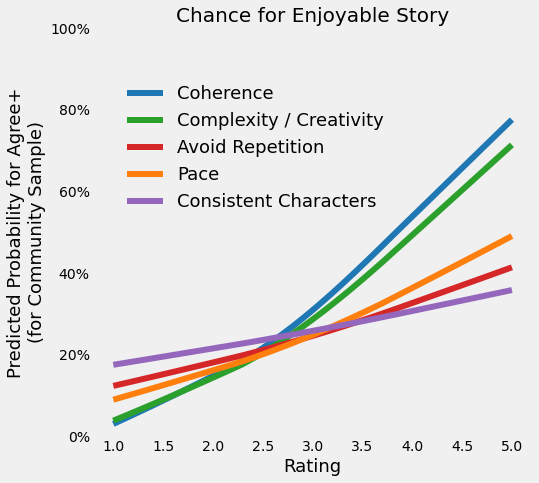

In [359]:
pred_df_template = pd.DataFrame()
pred_df_template["plot_values"] = np.arange(1.0, 5.1, 0.1)
pred_df_template[["tss_coh_cent", "tss_cre_cent",
                  "tss_avoid_rep_cent", "tss_pac_cent", "tss_conch_cent",
                  "word_count_cent"]] = 0
pred_df_template["sample"] = "Community"

pred_vars = [("Coherence", "tss_coh", "tab:blue"),
             ("Complexity / Creativity", "tss_cre", "tab:green"),
             ("Avoid Repetition", "tss_avoid_rep", "tab:red"),
             ("Pace", "tss_pac", "tab:orange"),
             ("Consistent Characters", "tss_conch", "tab:purple")]

fig, ax = plt.subplots(figsize=(7, 7))

for var in pred_vars:
    # Construct prediction df
    pred_df = pred_df_template.copy()
    var_full = var[0]
    var_short = var[1]
    color = var[2]
    pred_df.rename(columns={"plot_values": var_full}, inplace=True)
    pred_df[var_short + "_cent"] = pred_df[var_full] - \
        tss_no_out[var_short].mean()
    pred_df["Pred. Prob Qual 1"] = log_reg_q1.predict(pred_df)

    pred_plot = sns.regplot(data=pred_df, y="Pred. Prob Qual 1",
                            x=var_full, scatter=False, ax=ax, label=var_full,
                            x_ci=None, lowess=True, color=color)

plt.grid(False)
#plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Predicted Probability for Agree+\n(for Community Sample)")
plt.xlabel("Rating")
ax.legend(fontsize=18, frameon=False, bbox_to_anchor=(.7, .9))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Chance for Enjoyable Story", fontsize=20)
plt.savefig("graphs/logreg_qual_1.png", bbox_inches="tight")
plt.show()

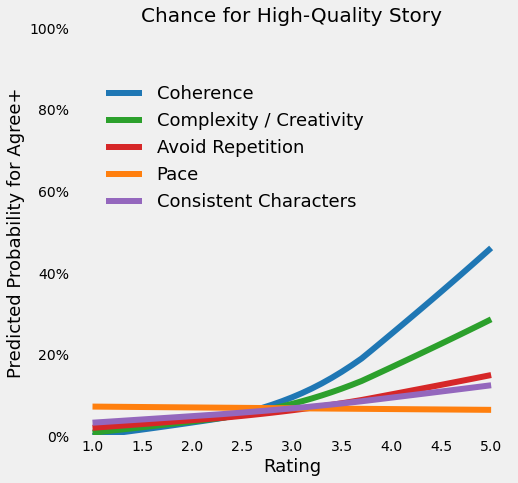

In [360]:
pred_df_template = pd.DataFrame()
pred_df_template["plot_values"] = np.arange(1.0, 5.1, 0.1)
pred_df_template[["tss_coh_cent", "tss_cre_cent",
                  "tss_avoid_rep_cent", "tss_pac_cent",
                  "tss_conch_cent",
                  "word_count_cent"]] = 0
pred_df_template["sample"] = "Community"

pred_vars = [("Coherence", "tss_coh", "tab:blue"),
             ("Complexity / Creativity", "tss_cre", "tab:green"),
             ("Avoid Repetition", "tss_avoid_rep", "tab:red"),
             ("Pace", "tss_pac", "tab:orange"),
             ("Consistent Characters", "tss_conch", "tab:purple")]

fig, ax = plt.subplots(figsize=(7, 7))

for var in pred_vars:
    # Construct prediction df
    pred_df = pred_df_template.copy()
    var_full = var[0]
    var_short = var[1]
    color = var[2]
    pred_df.rename(columns={"plot_values": var_full}, inplace=True)
    pred_df[var_short + "_cent"] = pred_df[var_full] - \
        tss_no_out[var_short].mean()
    pred_df["Pred. Prob Qual 2"] = log_reg_q2.predict(pred_df)

    pred_plot = sns.regplot(data=pred_df, y="Pred. Prob Qual 2",
                            x=var_full, scatter=False, ax=ax, label=var_full,
                            x_ci=None, lowess=True, color=color)

plt.grid(False)
#plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Predicted Probability for Agree+")
plt.xlabel("Rating")
ax.legend(fontsize=18, frameon=False, bbox_to_anchor=(.7, .9))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Chance for High-Quality Story", fontsize=20)
plt.savefig("graphs/logreg_qual_2.png", bbox_inches="tight")
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

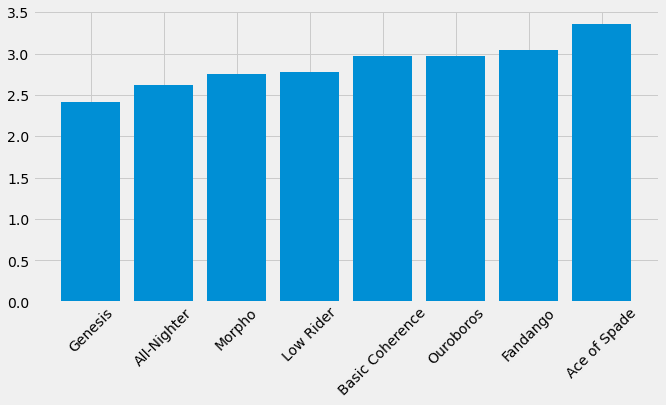

In [361]:
qual = tss_no_out.groupby('preset_label').mean(
)[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_1")

figure = plt.figure(figsize=(10, 5))
plt.bar(qual.index, qual["tss_qua_1"])
plt.xticks(rotation=45)

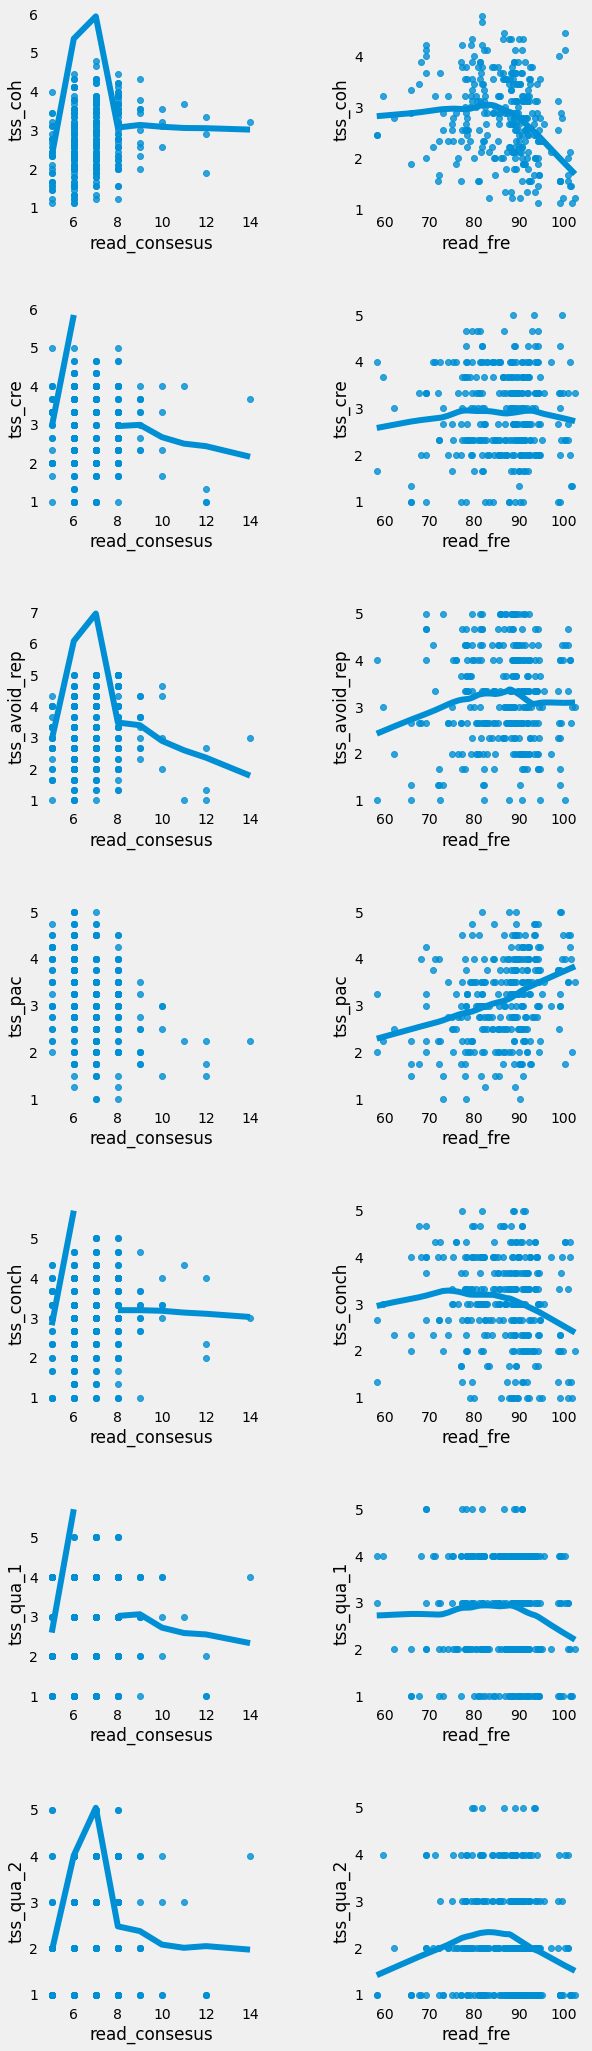

In [362]:
fig, axes = plt.subplots(7, 2, figsize=(10, 30))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_consesus", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_fre", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_consesus", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_fre", lowess=True, ax=axes[1, 1])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_consesus", lowess=True, ax=axes[2, 0])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_fre", lowess=True, ax=axes[2, 1])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_consesus", lowess=True, ax=axes[3, 0])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_fre", lowess=True, ax=axes[3, 1])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_consesus", lowess=True, ax=axes[4, 0])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_fre", lowess=True, ax=axes[4, 1])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_consesus", lowess=True, ax=axes[5, 0])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_fre", lowess=True, ax=axes[5, 1])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_consesus", lowess=True, ax=axes[6, 0])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_fre", lowess=True, ax=axes[6, 1])
for ax in fig.axes:
    ax.grid(False)

plt.show()

In [363]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["read_cent"] = tss_df["read_consesus"].apply(
    lambda x: x-tss_df["read_consesus"].mean())  # centering

tss_df["read_cent**2"] = tss_df["read_cent"]*tss_df["read_cent"]
tss_df["read_cent**3"] = tss_df["read_cent"]**3
tss_df["read_cent**4"] = tss_df["read_cent"]**4
tss_df["read_cent**5"] = tss_df["read_cent"]**5

lin_model = linreg()

pred_li = [("linear", "read_cent"), ("quadratic", "read_cent**2"),
           ("cubic", "read_cent**3"), ("quartic", "read_cent**4"),
           ("quintic", "read_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep",
              "tss_pac", "tss_conch", "tss_qua_1", "tss_qua_2"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

Model performance for linear model predicting tss_coh:
r-square: 0.0355    RMSE: 0.7905
Model performance for quadratic model predicting tss_coh:
r-square: 0.0467    RMSE: 0.7851
Model performance for cubic model predicting tss_coh:
r-square: 0.0446    RMSE: 0.7859
Model performance for quartic model predicting tss_coh:
r-square: 0.0039    RMSE: 0.8022
Model performance for quintic model predicting tss_coh:
r-square: -0.2885    RMSE: 0.8829

Model performance for linear model predicting tss_cre:
r-square: -0.0198    RMSE: 0.9238
Model performance for quadratic model predicting tss_cre:
r-square: -0.0620    RMSE: 0.9387
Model performance for cubic model predicting tss_cre:
r-square: -0.2644    RMSE: 0.9909
Model performance for quartic model predicting tss_cre:
r-square: -0.7748    RMSE: 1.0693
Model performance for quintic model predicting tss_cre:
r-square: -4.2533    RMSE: 1.3386

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0292    RMSE: 1.0555
Model per

In [391]:
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]

marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros", "Basic Coherence", "Low Rider",
                               "All-Nighter", "Morpho"],
                              ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch",
                               "tss_coh 90% CI margin", "tss_cre 90% CI margin",
                               "tss_avoid_rep 90% CI margin", "tss_pac 90% CI margin",
                               "tss_conch 90% CI margin",
                               "tss_coh adj_p", "tss_cre adj_p",
                               "tss_avoid_rep adj_p", "tss_pac adj_p",
                               "tss_conch adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho"], outcome] = marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho"], outcome].apply(
        lambda x: marg_means_df.loc["Intercept", outcome]+x)

marg_means_df.rename(index={"Intercept": "Grand Mean"}, inplace=True)
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_cre", "Complexity / Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_pac", "Pace")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_conch", "Consistent Characters")

In [392]:
marg_means_df

,Coherence,Complexity / Creativity,Avoiding Repitition,Pace,Consistent Characters,Coherence 90% CI margin,Complexity / Creativity 90% CI margin,Avoiding Repitition 90% CI margin,Pace 90% CI margin,Consistent Characters 90% CI margin,Coherence adj_p,Complexity / Creativity adj_p,Avoiding Repitition adj_p,Pace adj_p,Consistent Characters adj_p
Grand Mean,2.807177,2.795026,3.388798,3.275255,2.944276,0.106315,0.126628,0.129949,0.116234,0.133832,NaN,NaN,NaN,NaN,NaN
Genesis,2.487136,2.890273,3.596193,3.372452,2.855752,0.173097,0.206170,0.211576,0.189246,0.217899,0.019977,0.996983,2.849413e-01,0.529845,0.875986
Ouroboros,2.746480,2.795553,3.453669,3.193375,2.967329,0.192905,0.229762,0.235788,0.210902,0.242834,0.809518,0.996983,6.994629e-01,0.596837,0.875986
Basic Coherence,2.809585,2.812902,3.516672,3.309275,3.053260,0.197240,0.234926,0.241087,0.215642,0.248291,0.983945,0.996983,6.114216e-01,0.794780,0.875986
Low Rider,2.894706,2.802288,3.445881,3.129375,2.867578,0.199441,0.237547,0.243777,0.218048,0.251061,0.809518,0.996983,6.994629e-01,0.529845,0.875986
All-Nighter,2.923798,2.703846,3.331609,3.445813,2.916511,0.197475,0.235206,0.241374,0.215899,0.248587,0.809518,0.996983,6.994629e-01,0.515729,0.875986
Morpho,2.744941,2.594634,2.453503,2.843471,2.858869,0.199534,0.237659,0.243891,0.218150,0.251179,0.809518,0.996983,7.819896e-09,0.009797,0.875986


In [393]:
# Update GSheet from Basileus
gc = gs.oauth()

gsheet = gc.open("Preset Analysis").worksheet("Data")
gsheet_df = gd.get_as_dataframe(gsheet, index_col="Preset")
gsheet_df.update(marg_means_df)
gd.set_with_dataframe(gsheet, gsheet_df, include_index=True)

In [396]:
mask = ((tss_no_out["preset_label"] == "Morpho") &
        (tss_no_out["tss_coh"] > 2.55) &
        (tss_no_out["tss_avoid_rep"] > 2.21) &
        (tss_no_out["tss_avoid_rep"] < 2.70) &
        (tss_no_out["sample"] == "Community")
        )

tss_no_out[mask]

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,tss_coh_cent,tss_cre_cent,tss_avoid_rep_cent,tss_pac_cent,tss_conch_cent,read_cent,read_cent**2,read_cent**3,read_cent**4,read_cent**5
35,R_3CN5VZmsHUKJjkB,MOR_HSF_9,Hard Sci-Fi,Morpho,Community,1.0,2.0,4.0,5.0,4.0,...,1.083714,-0.900685,-0.535388,0.860445,0.963470,1.167808,1.363776,1.592629,1.859885,2.171989
121,R_12zPB6INQyY4tJm,MOR_HR_9,Historical Romance,Morpho,Community,4.0,4.0,4.0,5.0,4.0,...,0.528158,-1.567352,-0.535388,-1.389555,0.963470,5.167808,26.706242,138.012736,713.223351,3685.801493
130,R_2yjXeVetzf9rcG5,MOR_HF_2,High Fantasy,Morpho,Community,5.0,5.0,4.0,4.0,4.0,...,0.417047,1.099315,-0.535388,0.360445,-0.369863,0.167808,0.028160,0.004725,0.000793,0.000133


In [399]:
print(tss_no_out.loc[35, outcome_li])
print(tss_no_out.loc[35, "full_story"])

tss_coh          3.888889
tss_cre               2.0
tss_avoid_rep    2.666667
tss_pac               4.0
tss_conch             4.0
Name: 35, dtype: object
"I have a message for you from the president," said Dr. Sato, handing over an envelope to me. "He's asking that we meet with him at his office this afternoon." I took it and thanked her before walking out of my apartment building into the bright sun. It was already noon on Mars—the longest day in the year here on the planet.
This meeting would be my final meeting with the president.
As the president's personal physician, I was in charge of his health and well-being. That meant I was in charge of his medical care, which was good, since I'd been the one to get him into this mess to begin with.
I walked down the main street, past the shops and restaurants. It was a beautiful day, and people were out and about enjoying it. The sun was shining, the temperature was warm, and I could hear music from a nearby restaurant that I recognized as a

In [401]:
print(tss_no_out.loc[130, outcome_li])
print(tss_no_out.loc[130, "full_story"])

tss_coh          3.222222
tss_cre               4.0
tss_avoid_rep    2.666667
tss_pac               3.5
tss_conch        2.666667
Name: 130, dtype: object
The sun was high in the sky when they arrived at their destination. The valley of the River Tethys flowed into a wide, shallow lake surrounded by mountains on all sides. A small village sat along its shores with two towers standing guard over it from either side like sentinels. It looked to be deserted but for some smoke rising up out of chimneys and the occasional bird flying overhead or flitting through trees.
"This is where we'll be staying," said Ayla.
"I see it," said Ithamar. "It looks like a nice place."
"You've never been to the Vale before?" asked Ithamar.
"No, but I've heard of it," said Ayla. "There's a great many fables about it."
"I think I know why," said Ithamar, looking at the village. "It looks very much like the Vale of the Silver Birch."
"Exactly," said Ayla. "But I'm certain it's not the same." She looked around a